
# LSTM Forecasting

**Goal.** Train and evaluate an LSTM to predict **next‑day Close** for a single ticker, using four predefined indicator sets.  
We:

1. Load config & data; enforce reproducibility.
2. Impute missing values (median) → add indicators → impute again.
3. (Optional) Check **stationarity** (ADF) and add stationary transforms for inspection.
4. Build **Target = Close(t+1)**.
5. Train/evaluate four indicator sets; pick the **best by Directional Accuracy** (DA).
6. Re‑train best set and produce.
7. Compute **permutation feature importance** (metric = DA).  
8. (Optional) Run drop‑column retrain analysis (slower).


## 0) Imports, logging, and random seeds

In [ ]:

import os, random, yaml, logging
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns, tensorflow as tf
from IPython.display import display
from run_saver import RunSaver

from data_loader import load_stock_data
from indicators import add_indicators
from preprocessing import normalize_features, df_to_windowed_df, windowed_df_to_date_X_y, impute_numeric_median
from model import build_lstm_model
from evaluation import compute_metrics, compute_directional_accuracy

logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# Determinism
os.environ['PYTHONHASHSEED'] = str(42)
random.seed(42); np.random.seed(42); tf.random.set_seed(42)


# unified plotting


In [ ]:
# === Unified plotting utilities ===
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from run_saver import RunSaver  # Ensure the correct class is imported from the module

def _ensure_datetime(dates):
    """Return a pandas.DatetimeIndex from list/array/Series of dates."""
    if isinstance(dates, (pd.DatetimeIndex, pd.Timestamp)):
        return dates
    try:
        return pd.to_datetime(dates)
    except Exception:
        # If your dates are indices from windowing, fall back to a simple range
        return pd.to_datetime(pd.Series(range(len(dates))), unit="D", origin="unix")

def _style_dates(ax):
    """Consistent, readable date axis."""
    locator = mdates.AutoDateLocator(minticks=5, maxticks=10)
    formatter = mdates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    for label in ax.get_xticklabels():
        label.set_rotation(0)

def plot_predictions(dates_train, y_train, train_pred,
                     dates_val, y_val, val_pred,
                     dates_test, y_test, test_pred,
                     title="Model Predictions (Train/Val/Test)",
                     save_path=None):
    """Unified prediction overlay with consistent style."""
    dt_train = _ensure_datetime(dates_train)
    dt_val   = _ensure_datetime(dates_val)
    dt_test  = _ensure_datetime(dates_test)

    plt.figure(figsize=(14, 6))
    # Train
    plt.plot(dt_train, y_train, linewidth=1.5, label="Train Actual")
    plt.plot(dt_train, train_pred, linewidth=1.5, linestyle="--", label="Train Predicted")
    # Val
    plt.plot(dt_val, y_val, linewidth=1.5, label="Val Actual")
    plt.plot(dt_val, val_pred, linewidth=1.5, linestyle="--", label="Val Predicted")
    # Test
    plt.plot(dt_test, y_test, linewidth=1.8, label="Test Actual")
    plt.plot(dt_test, test_pred, linewidth=1.8, linestyle="--", label="Test Predicted")

    ax = plt.gca()
    _style_dates(ax)
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.grid(True, alpha=0.3)
    plt.legend(ncol=3)
    plt.tight_layout()
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, bbox_inches="tight", dpi=150)
    plt.show()

def plot_test_zoomed(dates_test, y_test, test_pred, last_n=120,
                     title="Test Set (Zoomed)",
                     save_path=None):
    """Zoom into last N test points with same style."""
    dt_test = _ensure_datetime(dates_test)
    if last_n is not None and last_n < len(dt_test):
        dt_test = dt_test[-last_n:]
        y_test = y_test[-last_n:]
        test_pred = test_pred[-last_n:]

    plt.figure(figsize=(14, 5))
    plt.plot(dt_test, y_test, linewidth=1.8, label="Test Actual")
    plt.plot(dt_test, test_pred, linewidth=1.8, linestyle="--", label="Test Predicted")

    ax = plt.gca()
    _style_dates(ax)
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, bbox_inches="tight", dpi=150)
    plt.show()

def plot_direction_accuracy_bars(dates_test, y_test, test_pred,
                                 title="Next-Day Direction Prediction Accuracy",
                                 save_path=None):
    """
    Green bar if sign(diff) matches, red if not. Uses the shared date styling.
    """
    dt_test = _ensure_datetime(dates_test)

    true_diff = np.diff(y_test)
    pred_diff = np.diff(test_pred)
    true_dir  = np.sign(true_diff)
    pred_dir  = np.sign(pred_diff)
    correct   = (true_dir == pred_dir)
    # Align dates due to diff
    dt_bars = dt_test[1:]

    colors = np.where(correct, "tab:green", "tab:red")
    plt.figure(figsize=(14, 3.5))
    plt.bar(dt_bars, true_dir, width=1, color=colors)
    plt.axhline(0, linewidth=1, linestyle="--")
    ax = plt.gca()
    _style_dates(ax)
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Direction (+1 / -1)")
    plt.tight_layout()
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, bbox_inches="tight", dpi=150)
    plt.show()



# === Extra plots: delta scatter & correlation heatmap ===
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_delta_scatter_painted(
    dates, actual, predicted,
    title="Delta Scatter (Predicted - Actual)",
    save_path=None,
    rolling_window=7,
    top_k_annotate=3,
    color_by="sign",          # "sign" or "direction"
    add_summary=True,
):
    import numpy as np, pandas as pd, matplotlib.pyplot as plt, matplotlib.dates as mdates
    from matplotlib.lines import Line2D

    dt = pd.to_datetime(dates)
    y  = np.asarray(actual).ravel()
    yhat = np.asarray(predicted).ravel()
    delta = yhat - y

    # Direction correctness (T+1 deltas)
    true_diff = np.diff(y)
    pred_diff = np.diff(yhat)
    correct = (np.sign(true_diff) == np.sign(pred_diff))
    dt2, delta2 = dt[1:], delta[1:]

    # Size by magnitude
    mag = np.abs(delta2)
    p90 = np.nanpercentile(mag, 90) if mag.size else 1.0
    sizes = 14 + 60 * (mag / (p90 + 1e-9))**0.7

    # Color & marker encoding
    if color_by == "sign":
        colors = np.where(delta2 >= 0, "tab:green", "tab:red")
        markers = np.array(["o"]*len(delta2))
        legend_handles = [
            Line2D([0], [0], marker='o', color='w', label='Over-prediction (Δ ≥ 0)',
                   markerfacecolor='tab:green', markeredgecolor='white', markersize=8),
            Line2D([0], [0], marker='o', color='w', label='Under-prediction (Δ < 0)',
                   markerfacecolor='tab:red', markeredgecolor='white', markersize=8),
        ]
    else:
        colors = np.where(correct, "tab:green", "tab:red")
        markers = np.where(correct, "o", "X")  # circle if correct, X if wrong
        legend_handles = [
            Line2D([0], [0], marker='o', color='w', label='Correct direction',
                   markerfacecolor='tab:green', markeredgecolor='white', markersize=8),
            Line2D([0], [0], marker='X', color='w', label='Wrong direction',
                   markerfacecolor='tab:red', markeredgecolor='white', markersize=8),
        ]

    # Plot (draw in two groups so shapes render)
    plt.figure(figsize=(14, 5))
    for mk in np.unique(markers):
        msk = (markers == mk)
        plt.scatter(dt2[msk], delta2[msk], s=sizes[msk], c=colors[msk],
                    alpha=0.9, edgecolors="white", linewidths=0.6, marker=mk)

    plt.axhline(0, linestyle="--", linewidth=1, color="0.5")

    # Rolling mean overlay (on full delta)
    if rolling_window and rolling_window > 1:
        roll = pd.Series(delta, index=dt).rolling(rolling_window).mean()
        plt.plot(roll.index, roll.values, linewidth=1.6, alpha=0.95, label=f"Rolling mean Δ ({rolling_window})")

    # 5/95% bands on aligned series
    if len(delta2) > 1:
        q5, q95 = np.nanquantile(delta2, [0.05, 0.95])
        plt.axhline(q5, linestyle=":", linewidth=1, color="0.4")
        plt.axhline(q95, linestyle=":", linewidth=1, color="0.4")

    # Label top-|Δ|
    if top_k_annotate and len(delta2) > 0:
        top_idx = np.argsort(-np.abs(delta2))[:top_k_annotate]
        for i in top_idx:
            plt.annotate(
                dt2[i].strftime("%Y-%m-%d"), (dt2[i], delta2[i]),
                xytext=(6, 6), textcoords="offset points",
                fontsize=8, bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="0.7", alpha=0.8)
            )

    # Date axis
    locator = mdates.AutoDateLocator(minticks=5, maxticks=10)
    formatter = mdates.ConciseDateFormatter(locator)
    ax = plt.gca()
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)

    if rolling_window and rolling_window > 1:
        legend_handles.append(Line2D([0], [0], color='C0', lw=1.6, label=f"Rolling mean Δ ({rolling_window})"))
    plt.legend(handles=legend_handles, loc="upper left")

    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Delta (Pred - Actual)")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, bbox_inches="tight", dpi=150)
    plt.show()

    if add_summary and len(delta2) > 0:
        print(f"[delta] mean={np.mean(delta2):.3f}, std={np.std(delta2):.3f}, "
              f"q05={np.nanquantile(delta2,0.05):.3f}, q95={np.nanquantile(delta2,0.95):.3f}, n={len(delta2)}")



def compute_corr_matrix_for_set(df, feat_cols, include_target=True, target_col="Target"):
    """
    Returns Pearson correlation matrix for selected features (+Target).
    Uses the ORIGINAL (unscaled) df you trained from (post-imputation).
    """
    cols = list(feat_cols)
    if include_target and target_col in df.columns:
        cols = cols + [target_col]
    # only numeric
    nums = df[cols].select_dtypes(include=[np.number]).copy()
    # drop all-NaN or constant columns to avoid NaNs in corr
    nunique = nums.nunique(dropna=True)
    keep = nunique[nunique > 1].index.tolist()
    nums = nums[keep]
    corr = nums.corr(method="pearson")
    return corr

from matplotlib.colors import LinearSegmentedColormap

def plot_corr_heatmap(corr_df, title="Correlation Heatmap (Salmon)", save_path=None):
    """
    Diverging heatmap centered at 0 using a custom 'salmon' palette.
    Annotates each cell with the correlation value.
    """
    labels = corr_df.columns.tolist()
    mat = corr_df.values

    # Build a diverging 'salmon' style colormap (blue -> white -> salmon)
    salmon_div = LinearSegmentedColormap.from_list(
        "salmon_div",
        ["#3B82F6", "#F8FAFC", "#FA8072", "#7F1D1D"],  # blue -> near white -> salmon -> dark red
        N=256
    )

    plt.figure(figsize=(1.1*len(labels)+2, 1.1*len(labels)+2))
    im = plt.imshow(mat, vmin=-1, vmax=1, cmap=salmon_div, aspect="auto")

    # Colorbar
    cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
    cbar.ax.set_ylabel("ρ", rotation=0, labelpad=10)

    # Ticks & labels
    plt.xticks(ticks=np.arange(len(labels)), labels=labels, rotation=45, ha="right")
    plt.yticks(ticks=np.arange(len(labels)), labels=labels)

    # Annotate each cell
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            v = mat[i, j]
            # Contrast-aware text color
            txtc = "white" if abs(v) > 0.5 else "black"
            plt.text(j, i, f"{v:.2f}", ha="center", va="center", fontsize=9, color=txtc)

    plt.title(title)
    plt.tight_layout()
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, bbox_inches="tight", dpi=150)
    plt.show()




def plot_pred_vs_actual(actual, predicted, title="Predicted vs Actual", save_path=None):
    import numpy as np, matplotlib.pyplot as plt, os
    y = np.asarray(actual).ravel(); yhat = np.asarray(predicted).ravel()
    lims = [min(y.min(), yhat.min()), max(y.max(), yhat.max())]

    plt.figure(figsize=(6,6))
    plt.scatter(y, yhat, s=10, alpha=0.7, edgecolors="white", linewidths=0.4)
    plt.plot(lims, lims, ls="--", lw=1, color="0.4")  # 45° line
    plt.title(title); plt.xlabel("Actual"); plt.ylabel("Predicted")
    plt.grid(True, alpha=0.3); plt.tight_layout()
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=150, bbox_inches="tight")
    plt.show()




### P&L utilities


### CSV logging helpers (LSTM)

 this configuration helps to store the data in each run for each ticker clean

In [ ]:
# ==== CSV logging helpers (LSTM) ====
import os, datetime as dt
import yaml
import pandas as pd
import numpy as np
from pathlib import Path
from run_saver import RunSaver  

# -- load config (once) --
with open("config/config.yaml", "r") as f:
    config = yaml.safe_load(f) or {}

# ---------- resolve core knobs from globals OR config defaults ----------

if "ticker" in globals():
    _ticker = str(ticker)
else:
    _tickers = config.get("tickers") or []
    _ticker = str(_tickers[0]) if len(_tickers) > 0 else str(config.get("ticker", "AAPL"))
ticker = _ticker  

# Splits
_sp = config.get("split", {}) or {} # safety
TRAIN_END = float(globals().get("TRAIN_END", _sp.get("train_end", 0.85))) # set default
VAL_END   = float(globals().get("VAL_END",   _sp.get("val_end",   0.92))) # set default
if VAL_END <= TRAIN_END:
    VAL_END = min(0.98, TRAIN_END + 0.05)
    print(f"[warn] val_end <= train_end; adjusted VAL_END to {VAL_END:.2f}")

# LSTM params
_lstm = config.get("lstm", {}) or {}
window_size   = int(globals().get("window_size",   _lstm.get("window_size", 60)))
epochs        = int(globals().get("epochs",        _lstm.get("epochs", 30)))
batch_size    = int(globals().get("batch_size",    _lstm.get("batch_size", 32)))
learning_rate = float(globals().get("learning_rate", _lstm.get("learning_rate", 1e-3)))

# ---------- per-ticker paths ----------
RESULTS_ROOT = Path("results") / ticker
PREDICTIONS_DIR = Path("output/predictions") / ticker
RESULTS_ROOT.mkdir(parents=True, exist_ok=True)
PREDICTIONS_DIR.mkdir(parents=True, exist_ok=True)

# primary per-ticker results CSV
RESULT_FILE_LSTM = str(RESULTS_ROOT / "lstm_results.csv")

#  master CSV path from config if you want to append there too
_paths = config.get("paths", {}) or {}
MASTER_FILE_LSTM = _paths.get("result_file_lstm", None)
if MASTER_FILE_LSTM:
    Path(os.path.dirname(MASTER_FILE_LSTM)).mkdir(parents=True, exist_ok=True)

# ---------- RunSaver (create exactly once per ticker) ----------
if ("saver" not in globals()) or (getattr(saver, "ticker", None) != ticker):
    saver = RunSaver(model_name="LSTM", ticker=ticker)
    saver.save_config(config)  # snapshot YAML only
    saver.note(
        f"Init run | ticker={ticker} | splits=({TRAIN_END},{VAL_END}) | "
        f"LSTM(ws={window_size}, ep={epochs}, bs={batch_size}, lr={learning_rate})"
    )

# ---------- helpers ----------
def _mape(y_true, y_pred, eps=1e-8):
    y_true = np.asarray(y_true, float)
    y_pred = np.asarray(y_pred, float)
    denom = np.maximum(np.abs(y_true), eps)
    return float(np.mean(np.abs((y_true - y_pred) / denom)) * 100.0)

def _split_metrics(dates, y_true, y_pred):
    """Return metrics dict for one split."""
    from evaluation import compute_metrics, compute_directional_accuracy
    rmse, mae = compute_metrics(y_true, y_pred)
    mape = _mape(y_true, y_pred)
    da   = compute_directional_accuracy(y_true, y_pred)
    return {
        "n": int(len(y_true)),
        "rmse": float(rmse),
        "mae": float(mae),
        "mape": float(mape),
        "da": float(da),
        "start_date": pd.to_datetime(dates[0]).date() if len(dates) else None,
        "end_date":   pd.to_datetime(dates[-1]).date() if len(dates) else None,
    }

def _ensure_results_csv(path):
    """Create the master results CSV with a header if missing."""
    if not os.path.exists(path):
        cols = [
            "timestamp","ticker","model","feature_set","k",
            "window_size","epochs","batch_size","learning_rate",
            "train_end","val_end","split","n",
            "rmse","mae","mape","da","start_date","end_date"
        ]
        Path(os.path.dirname(path)).mkdir(parents=True, exist_ok=True)
        pd.DataFrame(columns=cols).to_csv(path, index=False)

def save_lstm_run_tables(
    ticker, best_name, feature_names,
    # splits
    d_tr, y_tr_true, y_tr_pred,
    d_va, y_va_true, y_va_pred,
    d_te, y_te_true, y_te_pred,
    # hyperparams
    window_size, epochs, batch_size, learning_rate,
    train_end, val_end,
    result_file=RESULT_FILE_LSTM,
    also_master=True  # append to MASTER_FILE_LSTM too if configured
):
    """
    1) Append split metrics rows (Train/Val/Test) to per-ticker results CSV
    2) Save a predictions CSV with all splits concatenated under output/predictions/<ticker>/
    """
    _ensure_results_csv(result_file)
    if MASTER_FILE_LSTM and also_master:
        _ensure_results_csv(MASTER_FILE_LSTM)

    now = dt.datetime.utcnow().isoformat()

    # --- metrics rows (one per split) ---
    rows = []
    for split, dates, yt, yp in [
        ("Train", d_tr, y_tr_true, y_tr_pred),
        ("Val",   d_va, y_va_true, y_va_pred),
        ("Test",  d_te, y_te_true, y_te_pred),
    ]:
        m = _split_metrics(dates, yt, yp)
        rows.append({
            "timestamp": now,
            "ticker": ticker,
            "model": "LSTM",
            "feature_set": best_name,
            "k": len(feature_names),
            "window_size": window_size,
            "epochs": epochs,
            "batch_size": batch_size,
            "learning_rate": learning_rate,
            "train_end": train_end,
            "val_end": val_end,
            "split": split,
            "n": m["n"],
            "rmse": m["rmse"],
            "mae": m["mae"],
            "mape": m["mape"],
            "da": m["da"],
            "start_date": m["start_date"],
            "end_date": m["end_date"],
        })

    # write to per-ticker CSV
    pd.DataFrame(rows).to_csv(result_file, mode="a", header=not os.path.exists(result_file), index=False)
    print(f"✅ Appended LSTM metrics to: {result_file}")

    # optionally append to a master CSV too
    if MASTER_FILE_LSTM and also_master:
        pd.DataFrame(rows).to_csv(MASTER_FILE_LSTM, mode="a", header=not os.path.exists(MASTER_FILE_LSTM), index=False)
        print(f"↳ also appended to master: {MASTER_FILE_LSTM}")

    # --- predictions table (all splits stacked) ---
    def _pred_df(split, dates, yt, yp):
        yt = np.asarray(yt).flatten()
        yp = np.asarray(yp).flatten()
        d  = pd.to_datetime(pd.Index(dates))
        delta = yp - yt
        true_dir = np.sign(np.diff(yt, prepend=yt[0]))      # keep same length
        pred_dir = np.sign(np.diff(yp, prepend=yp[0]))
        return pd.DataFrame({
            "Date": d,
            "Split": split,
            "Actual": yt,
            "Predicted": yp,
            "Delta": delta,
            "CorrectDirection": (true_dir == pred_dir).astype(int)
        })

    pred_all = pd.concat([
        _pred_df("Train", d_tr, y_tr_true, y_tr_pred),
        _pred_df("Val",   d_va, y_va_true, y_va_pred),
        _pred_df("Test",  d_te, y_te_true, y_te_pred),
    ], ignore_index=True)

    pred_path = PREDICTIONS_DIR / f"{ticker}_{best_name}_predictions.csv"
    pred_all.to_csv(pred_path, index=False)
    print(f"✅ Saved predictions table: {pred_path}")

# --- FIX: redefine append_per_set_summary to support P&L and keep CSV schema safe ---
import os
from pathlib import Path
import numpy as np
import pandas as pd

def append_per_set_summary(
    ticker, set_name, k,
    da_val, rmse_val, mae_val, mape_val,
    da_test, rmse_test, mae_test, mape_test,
    window_size, epochs, batch_size, learning_rate,
    train_end, val_end,
    result_file,
    also_master=True,
    # NEW:
    pnl_val=None, pnl_test=None
):
    """
    Append two rows (Val/Test) with metrics (+ optional P&L) to the results CSV.
    If the existing CSV lacks the 'pnl' column, this function will merge schemas safely.
    """

    ts = pd.Timestamp.utcnow().isoformat()

    rows = [
        dict(timestamp=ts, ticker=ticker, model="LSTM", feature_set=set_name, k=k,
             window_size=window_size, epochs=epochs, batch_size=batch_size, learning_rate=learning_rate,
             train_end=train_end, val_end=val_end, split="Val", n=np.nan,
             rmse=float(rmse_val), mae=float(mae_val), mape=float(mape_val), da=float(da_val),
             start_date=None, end_date=None, pnl=(None if pnl_val is None else float(pnl_val))),
        dict(timestamp=ts, ticker=ticker, model="LSTM", feature_set=set_name, k=k,
             window_size=window_size, epochs=epochs, batch_size=batch_size, learning_rate=learning_rate,
             train_end=train_end, val_end=val_end, split="Test", n=np.nan,
             rmse=float(rmse_test), mae=float(mae_test), mape=float(mape_test), da=float(da_test),
             start_date=None, end_date=None, pnl=(None if pnl_test is None else float(pnl_test))),
    ]
    new_df = pd.DataFrame(rows)

    def _write_with_merged_schema(path: str, add_df: pd.DataFrame):
        Path(os.path.dirname(path)).mkdir(parents=True, exist_ok=True)
        if os.path.exists(path) and os.path.getsize(path) > 0:
            try:
                old = pd.read_csv(path)
            except Exception:
                old = pd.DataFrame()
            all_cols = list(dict.fromkeys(list(old.columns) + list(add_df.columns)))
            old = old.reindex(columns=all_cols)
            add_df = add_df.reindex(columns=all_cols)
            out = pd.concat([old, add_df], ignore_index=True)
        else:
            out = add_df
        out.to_csv(path, index=False)

    # write per-ticker results
    _write_with_merged_schema(result_file, new_df)

    # optionally write to master CSV if configured
    if also_master and 'MASTER_FILE_LSTM' in globals() and MASTER_FILE_LSTM:
        _write_with_merged_schema(MASTER_FILE_LSTM, new_df)


In [ ]:
# ====  CSV logging helpers ====
import os, datetime as dt
import pandas as pd
import numpy as np
with open("config/config.yaml", "r") as f:
    config = yaml.safe_load(f)

RESULT_FILE_LSTM = config["paths"].get("result_file_LSTM", "results/LSTM_results.csv")
os.makedirs(os.path.dirname(RESULT_FILE_LSTM), exist_ok=True)
os.makedirs("output/predictions", exist_ok=True)

def _mape(y_true, y_pred, eps=1e-8):
    y_true = np.asarray(y_true, float)
    y_pred = np.asarray(y_pred, float)
    denom = np.maximum(np.abs(y_true), eps)
    return float(np.mean(np.abs((y_true - y_pred) / denom)) * 100.0)

def _split_metrics(dates, y_true, y_pred):
    """Return metrics dict for one split."""
    from evaluation import compute_metrics, compute_directional_accuracy
    rmse, mae = compute_metrics(y_true, y_pred)
    mape = _mape(y_true, y_pred)
    da   = compute_directional_accuracy(y_true, y_pred)
    return {
        "n": int(len(y_true)),
        "rmse": float(rmse),
        "mae": float(mae),
        "mape": float(mape),
        "da": float(da),
        "start_date": pd.to_datetime(dates[0]).date() if len(dates) else None,
        "end_date":   pd.to_datetime(dates[-1]).date() if len(dates) else None,
    }

def _ensure_results_csv(path):
    """Create the master results CSV with a header if missing."""
    if not os.path.exists(path):
        cols = [
            "timestamp","ticker","model","feature_set","k",
            "window_size","epochs","batch_size","learning_rate",
            "train_end","val_end","split","n",
            "rmse","mae","mape","da","start_date","end_date"
        ]
        pd.DataFrame(columns=cols).to_csv(path, index=False)

def save_LSTM_run_tables(
    ticker, best_name, feature_names,
    # splits
    d_tr, y_tr_true, y_tr_pred,
    d_va, y_va_true, y_va_pred,
    d_te, y_te_true, y_te_pred,
    # hyperparams
    window_size, epochs, batch_size, learning_rate,
    train_end, val_end,
    result_file=RESULT_FILE_LSTM,
):
    """
    1) Append split metrics rows (Train/Val/Test) to results/lstm_results.csv
    2) Save a predictions CSV with all splits concatenated
    """
    _ensure_results_csv(result_file)
    now = dt.datetime.utcnow().isoformat()

    # --- metrics rows (one per split) ---
    rows = []
    for split, dates, yt, yp in [
        ("Train", d_tr, y_tr_true, y_tr_pred),
        ("Val",   d_va, y_va_true, y_va_pred),
        ("Test",  d_te, y_te_true, y_te_pred),
    ]:
        m = _split_metrics(dates, yt, yp)
        rows.append({
            "timestamp": now,
            "ticker": ticker,
            "model": "lstm",
            "feature_set": best_name,
            "k": len(feature_names),
            "window_size": window_size,
            "epochs": epochs,
            "batch_size": batch_size,
            "learning_rate": learning_rate,
            "train_end": train_end,
            "val_end": val_end,
            "split": split,
            "n": m["n"],
            "rmse": m["rmse"],
            "mae": m["mae"],
            "mape": m["mape"],
            "da": m["da"],
            "start_date": m["start_date"],
            "end_date": m["end_date"],
        })

    pd.DataFrame(rows).to_csv(result_file, mode="a", header=False, index=False)
    print(f"✅ Appended LSTM metrics to: {result_file}")



    # --- predictions table (all splits stacked) ---
    def _pred_df(split, dates, yt, yp):
        yt = np.asarray(yt).flatten()
        yp = np.asarray(yp).flatten()
        d  = pd.to_datetime(pd.Index(dates))
        delta = yp - yt
        # correct direction relative to next-day move (sign of diff)
        true_dir = np.sign(np.diff(yt, prepend=yt[0]))      # prepend to keep length
        pred_dir = np.sign(np.diff(yp, prepend=yp[0]))
        return pd.DataFrame({
            "Date": d,
            "Split": split,
            "Actual": yt,
            "Predicted": yp,
            "Delta": delta,
            "CorrectDirection": (true_dir == pred_dir).astype(int)
        })

    pred_all = pd.concat([
        _pred_df("Train", d_tr, y_tr_true, y_tr_pred),
        _pred_df("Val",   d_va, y_va_true, y_va_pred),
        _pred_df("Test",  d_te, y_te_true, y_te_pred),
    ], ignore_index=True)

    pred_path = f"output/predictions/{ticker}_{best_name}_predictions.csv"
    pred_all.to_csv(pred_path, index=False)
    print(f"✅ Saved predictions table: {pred_path}")


# call this helper inside your evaluation loop:
def append_per_set_summary(
    ticker, set_name, k, da_val, rmse_val, mae_val, mape_val,
    da_test, rmse_test, mae_test, mape_test,
    window_size, epochs, batch_size, learning_rate,
    train_end, val_end,
    result_file=RESULT_FILE_LSTM,
):
    _ensure_results_csv(result_file)
    now = dt.datetime.utcnow().isoformat()
    # We write two rows (Val/Test) under the same set+hyperparams for easy pivoting later
    pd.DataFrame([
        dict(timestamp=now, ticker=ticker, model="lstm", feature_set=set_name, k=k,
             window_size=window_size, epochs=epochs, batch_size=batch_size, learning_rate=learning_rate,
             train_end=train_end, val_end=val_end, split="Val", n=np.nan,
             rmse=rmse_val, mae=mae_val, mape=mape_val, da=da_val, start_date=None, end_date=None),
        dict(timestamp=now, ticker=ticker, model="lstm", feature_set=set_name, k=k,
             window_size=window_size, epochs=epochs, batch_size=batch_size, learning_rate=learning_rate,
             train_end=train_end, val_end=val_end, split="Test", n=np.nan,
             rmse=rmse_test, mae=mae_test, mape=mape_test, da=da_test, start_date=None, end_date=None),
    ]).to_csv(result_file, mode="a", header=False, index=False)

def save_split_metrics_table(
    set_name, ticker,
    d_tr, tr_true, tr_pred,
    d_va, va_true, va_pred,
    d_te, te_true, te_pred,
    out_dir="output/sets"
):
    """Create a tidy per-split metrics table (RMSE/MAE/MAPE/DA), print it, and save CSV."""
    rmse_tr, mae_tr = compute_metrics(tr_true, tr_pred)
    rmse_va, mae_va = compute_metrics(va_true, va_pred)
    rmse_te, mae_te = compute_metrics(te_true, te_pred)

    def _mape_local(y, yhat):
        eps = 1e-8
        y = np.asarray(y, float); yhat = np.asarray(yhat, float)
        return float(np.mean(np.abs((y - yhat) / np.maximum(np.abs(y), eps))) * 100.0)

    m = pd.DataFrame([
        dict(Split="Train", RMSE=rmse_tr, MAE=mae_tr, MAPE=_mape_local(tr_true, tr_pred), DA=compute_directional_accuracy(tr_true, tr_pred), n=len(tr_true)),
        dict(Split="Val",   RMSE=rmse_va, MAE=mae_va, MAPE=_mape_local(va_true, va_pred), DA=compute_directional_accuracy(va_true, va_pred), n=len(va_true)),
        dict(Split="Test",  RMSE=rmse_te, MAE=mae_te, MAPE=_mape_local(te_true, te_pred), DA=compute_directional_accuracy(te_true, te_pred), n=len(te_true)),
    ])
    print("\n[metrics table]")
    print(m.round(4).to_string(index=False))

    os.makedirs(out_dir, exist_ok=True)
    path = os.path.join(out_dir, f"{ticker}_{set_name}_metrics.csv")
    m.to_csv(path, index=False)
    try:
        saver.save_df(m, f"metrics_{set_name}")  # also into run folder
    except Exception:
        pass
    print(f"[save] Metrics CSV → {path}")
    return m



## 2) Load config & set split percentages

In [ ]:

with open("config/config.yaml", "r") as f:
    config = yaml.safe_load(f)

# Percent-based split (defaults if missing)
sp = config.get("split", {})
TRAIN_END = float(sp.get("train_end", 0.85))  
VAL_END   = float(sp.get("val_end",   0.92))  

# Modeling params
window_size = int(config["lstm"]["window_size"])
epochs      = int(config["lstm"]["epochs"])
batch_size  = int(config["lstm"]["batch_size"])
learning_rate = float(config["lstm"]["learning_rate"])

# (Optional) features.stationary toggle if you later add to config
USE_STATIONARY_FEATURES = bool(config.get("features", {}).get("stationary", False))

# Ticker & folders
ticker     = config["tickers"][0]
csv_folder = config["paths"]["csv_folder"]
model_dir  = config["paths"]["model_folder_lstm"]
os.makedirs("output", exist_ok=True); os.makedirs(model_dir, exist_ok=True)

print("Ticker:", ticker)
print("Split (train_end, val_end):", TRAIN_END, VAL_END)


## 3) Load data & ensure datetime index

In [ ]:
## 3) Load data & ensure datetime index (robust)

# Load data
df = load_stock_data(csv_folder, [ticker])[0]

# --- 3.1 Ensure a clean DatetimeIndex (tz-naive, sorted, unique) ---
def _ensure_datetime_index(df: pd.DataFrame) -> pd.DataFrame:
    # If index already datetime, normalize tz; else try common date columns
    if isinstance(df.index, pd.DatetimeIndex):
        idx = df.index
    elif "Date" in df.columns:
        idx = pd.to_datetime(df["Date"], errors="coerce")
        df = df.drop(columns=["Date"])
    elif "date" in df.columns:
        idx = pd.to_datetime(df["date"], errors="coerce")
        df = df.drop(columns=["date"])
    else:
        # last resort: try to parse current index
        idx = pd.to_datetime(df.index, errors="coerce")

    # Make tz-naive for Matplotlib and consistency
    try:
        if getattr(idx, "tz", None) is not None:
            idx = idx.tz_convert(None)  # if tz-aware
    except AttributeError:
        pass  # idx may be plain Index

    df.index = idx
    # Drop NaT index rows
    df = df[~df.index.to_series().isna()]
    # Sort by time
    df = df.sort_index()

    # Deduplicate timestamps (keep last)
    if df.index.has_duplicates:
        dup_ct = df.index.duplicated(keep="last").sum()
        print(f"[warn] Found {dup_ct} duplicate timestamps — keeping last occurrence.")
        df = df[~df.index.duplicated(keep="last")]

    # Sticky copy to recover index later if some helper resets it
    df["__DATE__"] = df.index
    return df

df = _ensure_datetime_index(df)

# --- 3.2 Optional: add missing business days (controlled by config) ---
dcfg = (config.get("data_cleaning") or {})
if bool(dcfg.get("add_missing_business_days", False)):
    full_idx = pd.bdate_range(df.index.min(), df.index.max(), name=df.index.name)
    before = len(df)
    df = df.reindex(full_idx)
    # Keep '__DATE__' aligned
    df["__DATE__"] = df.index
    print(f"[info] Reindexed to business days: {before} → {len(df)} rows (NaNs will be imputed).")

# --- 3.3 Basic numeric coercion & Close check ---
# Coerce obvious numeric columns to numeric (silently sets bad parses to NaN → imputed later)
for col in df.columns:
    if col not in ["__DATE__"]:
        # don’t blindly coerce strings like tickers; most financial cols parse fine
        try:
            df[col] = pd.to_numeric(df[col], errors="ignore")
        except Exception:
            pass

# Drop rows with missing Close only (others will be imputed)
missing_close = df["Close"].isna().sum() if "Close" in df.columns else None
if "Close" not in df.columns:
    raise ValueError("Expected column 'Close' not found in input data.")
if missing_close:
    print(f"[warn] Dropping {missing_close} rows with missing Close.")
    df = df.dropna(subset=["Close"])

print(
    "Data loaded:",
    f"shape={df.shape},",
    f"range=[{df.index.min().date()} .. {df.index.max().date()}],",
    f"freq≈{pd.infer_freq(df.index) or 'irregular'}"
)

# Quick peek
display(df.head(3))
display(df.tail(3))



## 4) Impute, add indicators, impute again

- Impute numeric columns with **median** (robust to outliers).
- Add technical indicators (from `indicators.py`).
- Impute again to remove rolling warm‑up NaNs.


In [ ]:
## 4) Impute, add indicators, impute again
from importlib import reload
import indicators
reload(indicators)
from indicators import add_indicators

# First pass: impute (stabilize rolling windows)
df = impute_numeric_median(df)

# Add technical indicators (use YAML windows if present)
ti_cfg = config.get("technical_indicators", {}) or {}
df = add_indicators(df, cfg=ti_cfg)

# Second pass: remove rolling warm-up NaNs via robust median fill
df = impute_numeric_median(df)

# (Optional) Safety: ensure the handful we rely on definitely exist with cfg windows
w_ma  = int(ti_cfg.get("ma_window", 20))
w_bb  = int(ti_cfg.get("bb_window", 20))
bb_k  = float(ti_cfg.get("bb_std", 2))
w_vol = int(ti_cfg.get("vol_window", 20))

if "SMA" not in df.columns:
    df["SMA"] = df["Close"].rolling(window=w_ma).mean()
if "EMA" not in df.columns:
    df["EMA"] = df["Close"].ewm(span=w_ma, adjust=False).mean()
if ("BB_upper" not in df.columns) or ("BB_lower" not in df.columns):
    ma_bb  = df["Close"].rolling(window=w_bb).mean()
    std_bb = df["Close"].rolling(window=w_bb).std()
    df["BB_upper"] = ma_bb + bb_k * std_bb
    df["BB_lower"] = ma_bb - bb_k * std_bb
if "Log_Return" not in df.columns:
    df["Log_Return"] = np.log(df["Close"] / df["Close"].shift(1))
if "RollingVolatility" not in df.columns:
    df["RollingVolatility"] = df["Log_Return"].rolling(window=w_vol).std()

# Final cleanup
df = impute_numeric_median(df)
display(df.tail())


# --- Harmonize indicator names & add light fallbacks so sets match df ---
def harmonize_indicator_columns(df: pd.DataFrame) -> pd.DataFrame:
    ren = {}

    # Common naming differences
    if "MACD" not in df.columns:
        for c in ["MACD_Line", "MACD_line", "macd", "ta_macd", "macd_line"]:
            if c in df.columns: ren[c] = "MACD"; break

    if "RSI" not in df.columns:
        for c in ["RSI_14", "rsi", "ta_rsi"]:
            if c in df.columns: ren[c] = "RSI"; break

    if "Momentum" not in df.columns:
        for c in ["MOM", "Mom", "momentum", "ta_mom"]:
            if c in df.columns: ren[c] = "Momentum"; break

    # Bollinger
    if "BB_upper" not in df.columns:
        for c in ["BollingerUpper", "BBand_Upper", "BB_upper_20_2"]:
            if c in df.columns: ren[c] = "BB_upper"; break
    if "BB_lower" not in df.columns:
        for c in ["BollingerLower", "BBand_Lower", "BB_lower_20_2"]:
            if c in df.columns: ren[c] = "BB_lower"; break

    # SMA / EMA
    if "SMA" not in df.columns:
        for c in ["SMA_20", "sma", "ta_sma"]:
            if c in df.columns: ren[c] = "SMA"; break
    if "EMA" not in df.columns:
        for c in ["EMA_20", "ema", "ta_ema"]:
            if c in df.columns: ren[c] = "EMA"; break

    # Rolling volatility
    if "RollingVolatility" not in df.columns:
        for c in ["Volatility", "Rolling_Volatility", "rv"]:
            if c in df.columns: ren[c] = "RollingVolatility"; break

    if ren:
        df = df.rename(columns=ren)

    # Minimal fallbacks if still missing (keeps pipeline from skipping *everything*)
    if "Momentum" not in df.columns and "Close" in df.columns:
        df["Momentum"] = df["Close"].diff().fillna(0.0)
    if "RollingVolatility" not in df.columns and "Log_Return" in df.columns:
        df["RollingVolatility"] = df["Log_Return"].rolling(20).std().fillna(0.0)
    if "SMA" not in df.columns and "Close" in df.columns:
        df["SMA"] = df["Close"].rolling(20).mean().fillna(method="bfill")
    if "EMA" not in df.columns and "Close" in df.columns:
        df["EMA"] = df["Close"].ewm(span=20, adjust=False).mean()

    # Final safety — remove any residual infs
    num_cols = df.select_dtypes(include=[np.number]).columns
    df[num_cols] = df[num_cols].replace([np.inf, -np.inf], np.nan)
    df[num_cols] = df[num_cols].fillna(df[num_cols].median(numeric_only=True))
    return df

df = harmonize_indicator_columns(df)



### 5) (Optional) Stationarity check (ADF) and light transforms

Directional models often benefit from features with **stable distributions**.  
report **ADF p‑values** for key numeric columns (lower = more stationary).  
If desired, set `USE_STATIONARY_FEATURES=True` in config to also add simple stationary transforms:
- First difference: `col_diff1 = col.diff()`  
- 60‑day rolling z‑score: `col_z = (col - MA60) / SD60`

> These additional columns are **not** used in the four indicator sets by default, but can be include them in custom sets.



In [ ]:

import warnings
from typing import Tuple

ST = config.get("stationarity", {})
USE_STATIONARITY = bool(ST.get("enable", False))
Z_WIN   = int(ST.get("zscore_window", 30))
ADD_PCT = bool(ST.get("add_pct", True))
ADD_LOG = bool(ST.get("add_log", True))
KPSS_REG = ST.get("kpss_reg", "c")  # 'c' (level) or 'ct' (trend)

def _adf_kpss_pvalues(s: pd.Series, kpss_reg: str = KPSS_REG) -> Tuple[float, float]:
    """Return (adf_p, kpss_p). Gracefully handles short series or missing statsmodels."""
    s = pd.Series(s).dropna().astype(float)
    if len(s) < 20:
        return (np.nan, np.nan)
    adf_p = np.nan; kpss_p = np.nan
    # ADF
    try:
        from statsmodels.tsa.stattools import adfuller
        adf_p = float(adfuller(s, autolag='AIC')[1])
    except Exception as e:
        warnings.warn(f"ADF failed for series: {e}")
    # KPSS
    try:
        from statsmodels.tsa.stattools import kpss
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            kpss_p = float(kpss(s, regression=kpss_reg, nlags="auto")[1])
    except Exception as e:
        warnings.warn(f"KPSS failed for series: {e}")
    return adf_p, kpss_p

def _stationarity_label(adf_p: float, kpss_p: float, alpha: float = 0.05) -> str:
    """
    A simple rule:
      - ADF p<α and KPSS p>α  => Stationary (both agree)
      - ADF p>=α and KPSS p<=α => Non-stationary (both agree)
      - Otherwise => Inconclusive (mixed)
    """
    if np.isnan(adf_p) or np.isnan(kpss_p):
        return "Unknown"
    if (adf_p < alpha) and (kpss_p > alpha):
        return "Stationary"
    if (adf_p >= alpha) and (kpss_p <= alpha):
        return "Non-stationary"
    return "Inconclusive"

# choose numeric columns to test (you can narrow this list)
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

rows = []
for c in num_cols:
    adf_p, kpss_p = _adf_kpss_pvalues(df[c])
    rows.append({"feature": c, "ADF_p": adf_p, "KPSS_p": kpss_p,
                 "Decision": _stationarity_label(adf_p, kpss_p)})

stationarity_report = pd.DataFrame(rows).sort_values(["Decision","ADF_p","KPSS_p"], na_position="last")
display(stationarity_report.head(30))

# Optional: add stationary transforms
if USE_STATIONARITY:
    base_cols = [c for c in num_cols if c != "Target"]
    for c in base_cols:
        # First difference
        df[f"{c}_diff1"] = df[c].diff()
        # Rolling z-score
        roll_mean = df[c].rolling(Z_WIN).mean()
        roll_std  = df[c].rolling(Z_WIN).std()
        df[f"{c}_z{Z_WIN}"] = (df[c] - roll_mean) / roll_std
        # Optional % returns
        if ADD_PCT:
            df[f"{c}_pct"] = df[c].pct_change()
        # Optional log + log-diff
        if ADD_LOG:
            # guard against non-positive values
            safe = df[c].where(df[c] > 0)
            df[f"{c}_log"] = np.log(safe)
            df[f"{c}_logdiff1"] = df[f"{c}_log"].diff()

    # Impute newly created transforms (rolling warm-up)
    df = impute_numeric_median(df)
    print(f"🧪 Added stationary transforms (diff1, z{Z_WIN}, pct={ADD_PCT}, log={ADD_LOG}). Shape now: {df.shape}")


## 6) Build the prediction target (next‑day Close T+1)

In [ ]:
## 6) Build the prediction target (T+1) from config

t_cfg = (config.get("target") or {})
t_type = str(t_cfg.get("type", "price")).lower().strip()

if t_type == "price":
    # Next-day price level
    df["Target"] = df["Close"].shift(-1)

elif t_type == "log_return":
    # Next-day log return (forward)
    df["Target"] = np.log(df["Close"].shift(-1) / df["Close"])

else:
    raise ValueError(f"Unsupported target.type '{t_type}'. Use 'price' or 'log_return'.")

# Clean target (remove inf/NaN created by shift/division) and proceed
df["Target"].replace([np.inf, -np.inf], np.nan, inplace=True)
df = df.dropna(subset=["Target"]).copy()

print(f"Target prepared ({t_type}); data shape: {df.shape}")



## 7) Define the four indicator sets


here is the list of the candidates per ticker : 


candidates:
  per_ticker:
    BRK-B:
      brkb_da_test_1: [RSI, BB_upper, Momentum, SMA]
      brkb_da_test_2: [RSI, MACD, SMA, EMA, RollingVolatility]
      brkb_pnl_test_1: [Momentum, SMA, RollingVolatility]
      brkb_pnl_test_2: [RSI, BB_upper, MACD, RollingVolatility]



    AAPL:
      aapl_da_test_1: [BB_upper, Momentum, EMA, RollingVolatility]
      aapl_da_test_2: [RSI, BB_lower, Momentum]
      aapl_pnl_test_1: [BB_upper, EMA]
      aapl_pnl_test_2: [BB_upper, SMA, EMA, RollingVolatility]


    AMZN:
      amzn_da_test_1: [RSI, BB_upper, BB_lower, EMA, RollingVolatility]
      amzn_da_test_2: [BB_upper, BB_lower, RollingVolatility]
      amzn_pnl_test_1: [RSI, BB_lower, RollingVolatility]
      amzn_pnl_test_2: [BB_upper, MACD, SMA, EMA]


    BAS:
      bas_da_test_1: [BB_upper, Momentum, EMA]
      bas_da_test_2: [RSI, BB_upper, Momentum, MACD, SMA, EMA]
      bas_pnl_test_1: [RSI, BB_upper, BB_lower, Momentum, SMA]
      bas_pnl_test_2: [BB_upper, Momentum, EMA]


    GOOGL:
      googl_da_test_1: [BB_upper, BB_lower, Momentum, MACD, RollingVolatility]
      googl_da_test_2: [BB_upper, EMA, RollingVolatility]
      googl_pnl_test_1: [BB_upper, BB_lower, MACD, EMA, RollingVolatility]
      googl_pnl_test_2: [BB_upper, BB_lower, MACD, RollingVolatility]


    NVDA:
      nvda_da_test_1: [BB_lower, SMA, RollingVolatility]
      nvda_da_test_2: [SMA]
      nvda_pnl_test_1: [EMA, RollingVolatility]
      nvda_pnl_test_2: [BB_upper, BB_lower, MACD, SMA]


    DTE:
      dte_da_test_1: [RSI, BB_upper, BB_lower, MACD]
      dte_da_test_2: [BB_upper, BB_lower, Momentum, EMA]
      dte_pnl_test_1: [RSI, BB_upper, BB_lower, Momentum]
      dte_pnl_test_2: [RSI, BB_upper, Momentum, MACD, SMA, EMA]


    SAP:
      sap_da_test_1: [BB_lower, Momentum, EMA, RollingVolatility]
      sap_da_test_2: [BB_lower]
      sap_pnl_test_1: [RSI, BB_lower, MACD, EMA, RollingVolatility]
      sap_pnl_test_2: [BB_lower, Momentum, MACD, RollingVolatility]

    SIE:
      sie_da_test_1: [RSI, SMA, EMA, RollingVolatility]
      sie_da_test_2: [BB_upper, BB_lower, Momentum, MACD, SMA, EMA, RollingVolatility]
      sie_pnl_test_1: [RSI, BB_lower]
      sie_pnl_test_2: [RSI, BB_upper, SMA, EMA]

    VOW3:
      vow3_da_test_1: [RSI, Momentum, EMA, RollingVolatility]
      vow3_da_test_2: [BB_upper, Momentum, RollingVolatility]
      vow3_pnl_test_1: [RSI, Momentum, MACD, SMA, EMA]
      vow3_pnl_test_2: [RSI, BB_upper, BB_lower, Momentum]
  

  
    




In [ ]:

# --- Candidate sets per ticker (no YAML call; mirrors your CNN behavior) ---
CANDIDATE_SETS_PER_TICKER = {
    "BRK-B": {
        "brkb_da_test_1": ["RSI", "BB_upper", "Momentum", "SMA"],
        "brkb_da_test_2": ["RSI", "MACD", "SMA", "EMA", "RollingVolatility"],
        "brkb_pnl_test_1": ["Momentum", "SMA", "RollingVolatility"],
        "brkb_pnl_test_2": ["RSI", "BB_upper", "MACD", "RollingVolatility"],
    },
    "AAPL": {
        "aapl_da_test_1": ["BB_upper", "Momentum", "EMA", "RollingVolatility"],
        "aapl_da_test_2": ["RSI", "BB_lower", "Momentum"],
        "aapl_pnl_test_1": ["BB_upper", "EMA"],
        "aapl_pnl_test_2": ["BB_upper", "SMA", "EMA", "RollingVolatility"],
    },
    "AMZN": {
        "amzn_da_test_1": ["RSI", "BB_upper", "BB_lower", "EMA", "RollingVolatility"],
        "amzn_da_test_2": ["BB_upper", "BB_lower", "RollingVolatility"],
        "amzn_pnl_test_1": ["RSI", "BB_lower", "RollingVolatility"],
        "amzn_pnl_test_2": ["BB_upper", "MACD", "SMA", "EMA"],
    },
    "BAS": {
        "bas_da_test_1": ["BB_upper", "Momentum", "EMA"],
        "bas_da_test_2": ["RSI", "BB_upper", "Momentum", "MACD", "SMA", "EMA"],
        "bas_pnl_test_1": ["RSI", "BB_upper", "BB_lower", "Momentum", "SMA"],
        "bas_pnl_test_2": ["BB_upper", "Momentum", "EMA"],
    },
    "GOOGL": {
        "googl_da_test_1": ["BB_upper", "BB_lower", "Momentum", "MACD", "RollingVolatility"],
        "googl_da_test_2": ["BB_upper", "EMA", "RollingVolatility"],
        "googl_pnl_test_1": ["BB_upper", "BB_lower", "MACD", "EMA", "RollingVolatility"],
        "googl_pnl_test_2": ["BB_upper", "BB_lower", "MACD", "RollingVolatility"],
    },
    "NVDA": {
        "nvda_da_test_1": ["BB_lower", "SMA", "RollingVolatility"],
        "nvda_da_test_2": ["SMA"],
        "nvda_pnl_test_1": ["EMA", "RollingVolatility"],
        "nvda_pnl_test_2": ["BB_upper", "BB_lower", "MACD", "SMA"],
    },
    "DTE": {
        "dte_da_test_1": ["RSI", "BB_upper", "BB_lower", "MACD"],
        "dte_da_test_2": ["BB_upper", "BB_lower", "Momentum", "EMA"],
        "dte_pnl_test_1": ["RSI", "BB_upper", "BB_lower", "Momentum"],
        "dte_pnl_test_2": ["RSI", "BB_upper", "Momentum", "MACD", "SMA", "EMA"],
    },
    "SAP": {
        "sap_da_test_1": ["BB_lower", "Momentum", "EMA", "RollingVolatility"],
        "sap_da_test_2": ["BB_lower"],
        "sap_pnl_test_1": ["RSI", "BB_lower", "MACD", "EMA", "RollingVolatility"],
        "sap_pnl_test_2": ["BB_lower", "Momentum", "MACD", "RollingVolatility"],
    },
    "SIE": {
        "sie_da_test_1": ["RSI", "SMA", "EMA", "RollingVolatility"],
        "sie_da_test_2": ["BB_upper", "BB_lower", "Momentum", "MACD", "SMA", "EMA", "RollingVolatility"],
        "sie_pnl_test_1": ["RSI", "BB_lower"],
        "sie_pnl_test_2": ["RSI", "BB_upper", "SMA", "EMA"],
    },
    "VOW3": {
        "vow3_da_test_1": ["RSI", "Momentum", "EMA", "RollingVolatility"],
        "vow3_da_test_2": ["BB_upper", "Momentum", "RollingVolatility"],
        "vow3_pnl_test_1": ["RSI", "Momentum", "MACD", "SMA", "EMA"],
        "vow3_pnl_test_2": ["RSI", "BB_upper", "BB_lower", "Momentum"],
    },
}

# Pick per-ticker dict; if missing, default to a simple generic pool
if ticker in CANDIDATE_SETS_PER_TICKER:
    CANDIDATE_SETS = CANDIDATE_SETS_PER_TICKER[ticker]
else:
    print(f"[warn] No predefined candidates for {ticker}. Using a generic pool.")
    CANDIDATE_SETS = {
        "generic_1": ["SMA", "EMA", "Momentum"],
        "generic_2": ["RSI", "BB_upper", "BB_lower"],
        "generic_3": ["RSI", "MACD", "RollingVolatility"],
    }

BASE_EXTRA_FEATURES = []   # keep this as-is
print("Candidate sets loaded:", list(CANDIDATE_SETS.keys()))



## 8) Utility functions (split, prep, train/eval, etc.)

In [ ]:
## 8) Utility functions (split, prep, train/eval, etc.)

def set_seed(s=42):
    os.environ['PYTHONHASHSEED'] = str(s)
    random.seed(s); np.random.seed(s); tf.random.set_seed(s)
    tf.keras.backend.clear_session()

def mape(y_true, y_pred, eps=1e-8):
    y_true = np.array(y_true, dtype=float); y_pred = np.array(y_pred, dtype=float)
    denom = np.maximum(np.abs(y_true), eps)
    return np.mean(np.abs((y_true - y_pred) / denom)) * 100.0

def _build_lstm_safe(window_size, n_feats, lr):
    """Handle builders that may/may not take learning_rate."""
    try:
        return build_lstm_model(window_size, n_feats, lr)
    except TypeError:
        return build_lstm_model(window_size, n_feats)

def _check_features_exist(df_cols, feat_cols):
    missing = [c for c in feat_cols if c not in df_cols]
    if missing:
        print(f"[skip] Missing features: {missing}")
    return missing

def split_by_percent(dates_arr, X_arr, y_arr, train_end=TRAIN_END, val_end=VAL_END, ensure_min=1):
    n = len(dates_arr)
    if n < 3:
        raise ValueError(f"Not enough samples after windowing: n={n}")
    i_tr_end  = max(ensure_min, min(int(n * train_end), n - 2))
    i_val_end = max(i_tr_end + ensure_min, min(int(n * val_end),  n - 1))
    X_tr, X_va, X_te = X_arr[:i_tr_end], X_arr[i_tr_end:i_val_end], X_arr[i_val_end:]
    y_tr, y_va, y_te = y_arr[:i_tr_end], y_arr[i_tr_end:i_val_end], y_arr[i_val_end:]
    d_tr, d_va, d_te = dates_arr[:i_tr_end], dates_arr[i_tr_end:i_val_end], dates_arr[i_val_end:]
    print(f"[split] n={n} → Train={len(d_tr)}, Val={len(d_va)}, Test={len(d_te)} "
          f"(train_end={train_end:.2f}, val_end={val_end:.2f})")
    if len(d_te) == 0:
        raise ValueError("Empty test split — increase val_end or reduce train_end.")
    return d_tr, d_va, d_te, X_tr, X_va, X_te, y_tr, y_va, y_te

def prepare_data_for_features(feat_cols):
    use_cols = feat_cols + BASE_EXTRA_FEATURES + ["Target"]
    # sanity on features first
    missing = _check_features_exist(df.columns, use_cols)
    if missing:
        raise ValueError(f"Required columns not found for set: {missing}")

    df_model = df[use_cols].copy()
    # Ensure we actually have a DatetimeIndex; fall back to sticky __DATE__ if present
    if not isinstance(df_model.index, pd.DatetimeIndex):
        if "__DATE__" in df.columns:
            df_model["__DATE__"] = pd.to_datetime(df["__DATE__"], errors="coerce")
            df_model = df_model.set_index("__DATE__")
        elif "Date" in df_model.columns:
            df_model["Date"] = pd.to_datetime(df_model["Date"], errors="coerce")
            df_model = df_model.set_index("Date")
        else:
            raise ValueError("DataFrame index is not a DatetimeIndex, and no '__DATE__' or 'Date' column is available.")

    feature_order = [c for c in df_model.columns if c != "Target"]

    # Scale + window
    print(f"[prep] Features(k={len(feature_order)}): {feature_order}")
    df_scaled, _, scaler_y = normalize_features(df_model, target_col="Target")
    windowed = df_to_windowed_df(df_scaled, window_size, target_col="Target")
    windowed = windowed.replace([np.inf, -np.inf], np.nan)
    num_cols_win = windowed.select_dtypes(include=[np.number]).columns
    if len(num_cols_win) > 0:
        windowed[num_cols_win] = windowed[num_cols_win].fillna(windowed[num_cols_win].median(skipna=True))

    dates_s, X_s, y_s = windowed_df_to_date_X_y(windowed, window_size)
    dates_s = pd.to_datetime(dates_s)  # nice formatting

    print(f"[prep] Windowed: X={X_s.shape} (n,ws,k) | y={y_s.shape} | "
          f"date_range=[{dates_s[0].date()}..{dates_s[-1].date()}]")
    return dates_s, X_s, y_s, scaler_y, feature_order

def train_eval_set(feat_cols, set_name):
    print(f"\n[train] Set '{set_name}' with features: {feat_cols}")
    dates_s, X_s, y_s, scaler_y_s, feature_order = prepare_data_for_features(feat_cols)
    d_tr, d_va, d_te, X_tr, X_va, X_te, y_tr, y_va, y_te = split_by_percent(dates_s, X_s, y_s)

    set_seed(42)
    model_s = _build_lstm_safe(window_size, X_s.shape[2], learning_rate)
    print(f"[model] Input: window_size={window_size}, n_features={X_s.shape[2]} | "
          f"epochs={epochs}, batch_size={batch_size}, lr={learning_rate}")
    _ = model_s.fit(X_tr, y_tr, validation_data=(X_va, y_va),
                    epochs=epochs, batch_size=batch_size, verbose=0)

    # Predictions (inverse-scaled) for all splits
    tr_pred = scaler_y_s.inverse_transform(model_s.predict(X_tr, verbose=0)).ravel()
    va_pred = scaler_y_s.inverse_transform(model_s.predict(X_va, verbose=0)).ravel()
    te_pred = scaler_y_s.inverse_transform(model_s.predict(X_te, verbose=0)).ravel()

    tr_true = scaler_y_s.inverse_transform(y_tr.reshape(-1,1)).ravel()
    va_true = scaler_y_s.inverse_transform(y_va.reshape(-1,1)).ravel()
    te_true = scaler_y_s.inverse_transform(y_te.reshape(-1,1)).ravel()

    # Metrics
    rmse_tr, mae_tr = compute_metrics(tr_true, tr_pred)
    rmse_va, mae_va = compute_metrics(va_true, va_pred)
    rmse_te, mae_te = compute_metrics(te_true, te_pred)

    da_tr  = compute_directional_accuracy(tr_true, tr_pred)
    da_va  = compute_directional_accuracy(va_true, va_pred)
    da_te  = compute_directional_accuracy(te_true, te_pred)

    mape_tr = mape(tr_true, tr_pred)
    mape_va = mape(va_true, va_pred)
    mape_te = mape(te_true, te_pred)

    print(f"[metrics] Train: n={len(tr_true)} | RMSE={rmse_tr:.4f} MAE={mae_tr:.4f} MAPE={mape_tr:.2f}% DA={da_tr:.4f}")
    print(f"[metrics] Val  : n={len(va_true)} | RMSE={rmse_va:.4f} MAE={mae_va:.4f} MAPE={mape_va:.2f}% DA={da_va:.4f}")
    print(f"[metrics] Test : n={len(te_true)} | RMSE={rmse_te:.4f} MAE={mae_te:.4f} MAPE={mape_te:.2f}% DA={da_te:.4f}")

    # Save per-set deltas (TEST)
    os.makedirs("output/sets", exist_ok=True)
    deltas_path = f"output/sets/{ticker}_{set_name}_deltas.csv"
    pd.DataFrame({
        "Date": d_te, "Actual": te_true, "Predicted": te_pred, "Delta": te_pred - te_true
    }).to_csv(deltas_path, index=False)
    print(f"[save] Test deltas → {deltas_path}")

    # Also save stacked predictions for all splits (useful later)
    preds_all_path = f"output/sets/{ticker}_{set_name}_preds_all_splits.csv"
    pd.DataFrame({
        "Date": np.concatenate([d_tr, d_va, d_te]),
        "Split": (["Train"]*len(d_tr)) + (["Val"]*len(d_va)) + (["Test"]*len(d_te)),
        "Actual": np.concatenate([tr_true, va_true, te_true]),
        "Predicted": np.concatenate([tr_pred, va_pred, te_pred]),
    }).to_csv(preds_all_path, index=False)
    print(f"[save] All-split predictions → {preds_all_path}")

    # Return concise summary + artifacts for later plotting/saving
    return {
        "set_name": set_name,
        "features": feat_cols,
        "n_features": X_s.shape[2],
        "DA_train": float(da_tr),  "RMSE_train": float(rmse_tr), "MAE_train": float(mae_tr), "MAPE_train%": float(mape_tr),
        "DA_val":   float(da_va),  "RMSE_val":   float(rmse_va), "MAE_val":   float(mae_va), "MAPE_val%":   float(mape_va),
        "DA_test":  float(da_te),  "RMSE_test":  float(rmse_te), "MAE_test":  float(mae_te), "MAPE_test%":  float(mape_te),
    }, dict(
        dates=(d_tr, d_va, d_te),
        truth=(tr_true, va_true, te_true),
        preds=(tr_pred, va_pred, te_pred),
        scaler_y=scaler_y_s,
        model=model_s,
        feature_order=feature_order,
    )


In [ ]:
# put this near the top (before section 9)
try:
    from evaluation import simulate_pnl   # ← adjust module name/path
except Exception as e:
    print("[warn] simulate_pnl import failed:", e)

# ensure detection sees it
# put this near the top (before section 9)
try:
    # simulate_pnl is defined in evaluation.py in your repo
    from evaluation import simulate_pnl
except Exception as e:
    simulate_pnl = None
    print(f"[warn] simulate_pnl import failed: {e}")

_HAVE_PNL = callable(simulate_pnl)



### 9) # === 9) Train & evaluate across candidate sets (with P&L), print-rich & robust ===


 - define a feature universe (features)
 - choose a search mode (forward_greedy | exhaustive_k | random_search)
 - score on *validation* DA to avoid test leakage
 - log all evaluated subsets and then *only* train/plot the best one


In [ ]:
# === 9) Train & evaluate across candidate sets (with P&L), print-rich & robust ===
import time
from pathlib import Path
from evaluation import simulate_pnl
# Reuse a saver if already created
try:
    saver
except NameError:
    saver = RunSaver("LSTM", ticker)
saver.note("Starting candidate evaluation")

CANDIDATE_OUT_DIR = Path("output/sets")
CANDIDATE_OUT_DIR.mkdir(parents=True, exist_ok=True)

# --- Backtest / P&L config ---
bt_cfg = (config.get("backtest") or {})
INITIAL_CASH = float(bt_cfg.get("initial_cash", 80_000))
PNL_OUT_DIR  = Path(bt_cfg.get("pnl_output_folder", str(saver.tables / "pnl")))
PNL_OUT_DIR.mkdir(parents=True, exist_ok=True)

def _build_lstm_safe(n_feats: int):
    """Handle builders that may/may not take learning_rate."""
    try:
        return build_lstm_model(window_size, n_feats, learning_rate)
    except TypeError:
        return build_lstm_model(window_size, n_feats)

_HAVE_PNL = ("simulate_pnl" in globals()) or ("simulate_pnl" in locals())

def eval_candidate_set(feat_cols, set_name):
    """Train LSTM on one candidate set and return split metrics + artifacts."""
    print(f"\n▶️  Preparing set: {set_name} | features={feat_cols}")

    # ---- prep ----
    dates_s, X_s, y_s, scaler_y_s, feature_order = prepare_data_for_features(feat_cols)
    print(f"[prep] rows_total={len(df)} | window_size={window_size} | windowed_n={len(dates_s)}")
    if X_s.shape[0] < 3:
        raise ValueError(f"{set_name}: only {X_s.shape[0]} samples after windowing (ws={window_size}).")

    d_tr, d_va, d_te, X_tr, X_va, X_te, y_tr, y_va, y_te = split_by_percent(
        dates_s, X_s, y_s, train_end=TRAIN_END, val_end=VAL_END
    )

    # ---- train ----
    set_seed(42)
    model = _build_lstm_safe(X_s.shape[2])
    print(f"[model] window_size={window_size}, n_features={X_s.shape[2]}, "
          f"epochs={epochs}, batch_size={batch_size}, lr={learning_rate}")
    t0 = time.time()
    _ = model.fit(X_tr, y_tr, validation_data=(X_va, y_va),
                  epochs=epochs, batch_size=batch_size, verbose=0)
    train_secs = time.time() - t0
    print(f"[train] done in {train_secs:.1f}s")

    # ---- predictions (inverse-scale) ----
    tr_pred = scaler_y_s.inverse_transform(model.predict(X_tr, verbose=0)).ravel()
    va_pred = scaler_y_s.inverse_transform(model.predict(X_va, verbose=0)).ravel()
    te_pred = scaler_y_s.inverse_transform(model.predict(X_te, verbose=0)).ravel()

    tr_true = scaler_y_s.inverse_transform(y_tr.reshape(-1, 1)).ravel()
    va_true = scaler_y_s.inverse_transform(y_va.reshape(-1, 1)).ravel()
    te_true = scaler_y_s.inverse_transform(y_te.reshape(-1, 1)).ravel()

    # ---- metrics ----
    rmse_tr, mae_tr = compute_metrics(tr_true, tr_pred)
    rmse_va, mae_va = compute_metrics(va_true, va_pred)
    rmse_te, mae_te = compute_metrics(te_true, te_pred)

    da_tr  = compute_directional_accuracy(tr_true, tr_pred)
    da_va  = compute_directional_accuracy(va_true, va_pred)
    da_te  = compute_directional_accuracy(te_true, te_pred)

    mape_tr = mape(tr_true, tr_pred)
    mape_va = mape(va_true, va_pred)
    mape_te = mape(te_true, te_pred)

    # --- save & print the split metrics table ---
    metrics_df = save_split_metrics_table(
        set_name, ticker,
        d_tr, tr_true, tr_pred,
        d_va, va_true, va_pred,
        d_te, te_true, te_pred,
        out_dir=str(CANDIDATE_OUT_DIR)
    )

    print(f"[metrics] Train n={len(tr_true)} | RMSE={rmse_tr:.4f} MAE={mae_tr:.4f} MAPE={mape_tr:.2f}% DA={da_tr:.4f}")
    print(f"[metrics] Val   n={len(va_true)} | RMSE={rmse_va:.4f} MAE={mae_va:.4f} MAPE={mape_va:.2f}% DA={da_va:.4f}")
    print(f"[metrics] Test  n={len(te_true)} | RMSE={rmse_te:.4f} MAE={mae_te:.4f} MAPE={mape_te:.2f}% DA={da_te:.4f}")

    # delta bias summary (Pred - Actual)
    delta_test = te_pred - te_true
    print(f"[delta] Test bias: mean Δ = {delta_test.mean():.4f} | median Δ = {np.median(delta_test):.4f}")

    # ---- P&L on TEST (robust gate + always record ratio field) ----
    pnl_result = None
    pnl_status = "skipped"
    if not _HAVE_PNL:
        pnl_status = "simulate_pnl_missing"
    elif globals().get("t_type", "price") != "price":
        pnl_status = f"target_is_{globals().get('t_type')}"
    elif len(te_true) < 2:
        pnl_status = "too_short_test"
    else:
        try:
            pnl_result, trade_log_df = simulate_pnl(
                te_true, te_pred,
                initial_cash=INITIAL_CASH,
                ticker=f"{ticker}_{set_name}",
                output_folder=str(PNL_OUT_DIR)
            )
            saver.save_json(pnl_result, f"pnl_{set_name}")
            saver.save_df(trade_log_df, f"pnl_trades_{set_name}")
            pnl_status = "ok"
            print(f"[pnl] ratio={pnl_result.get('P&L Ratio', np.nan)} | "
                  f"wins={pnl_result.get('Winning Trades')} losses={pnl_result.get('Losing Trades')} | "
                  f"gain={pnl_result.get('Total Gain')} loss={pnl_result.get('Total Loss')}")
            print(f"[save] Trade log CSV → {PNL_OUT_DIR / ('pnl_research_style_' + ticker + '.csv')}")
        except Exception as e:
            pnl_status = f"error: {e}"
    print(f"[pnl] status={pnl_status}")

    # ---- save per-set artifacts ----
    model_path = saver.save_model(model, f"LSTM_{ticker}_{set_name}")
    saver.save_scalers(scaler_y=scaler_y_s, name=f"y_{set_name}")

    saver.save_df(pd.DataFrame({
        "Date": d_te, "Actual": te_true, "Predicted": te_pred, "Delta": te_pred - te_true
    }), f"deltas_{set_name}")

    saver.save_df(pd.DataFrame({
        "Date": np.concatenate([d_tr, d_va, d_te]),
        "Split": (["Train"] * len(d_tr)) + (["Val"] * len(d_va)) + (["Test"] * len(d_te)),
        "Actual": np.concatenate([tr_true, va_true, te_true]),
        "Predicted": np.concatenate([tr_pred, va_pred, te_pred]),
    }), f"preds_{set_name}_all_splits")

    saver.save_json({
        "ticker": ticker,
        "set_name": set_name,
        "features": feat_cols,
        "k": len(feat_cols),
        "metrics": {
            "train": {"RMSE": float(rmse_tr), "MAE": float(mae_tr), "MAPE": float(mape_tr), "DA": float(da_tr)},
            "val":   {"RMSE": float(rmse_va), "MAE": float(mae_va), "MAPE": float(mape_va), "DA": float(da_va)},
            "test":  {"RMSE": float(rmse_te), "MAE": float(mae_te), "MAPE": float(mape_te), "DA": float(da_te)},
        },
        "model_path": str(model_path),
        "train_seconds": float(train_secs),
        "pnl": pnl_result if pnl_result is not None else None,
        "pnl_status": pnl_status,
    }, f"summary_{set_name}")

    # ---- also append concise Val/Test rows to global results CSV ----
    try:
        append_per_set_summary(
            ticker=ticker, set_name=set_name, k=len(feat_cols),
            da_val=float(da_va), rmse_val=float(rmse_va), mae_val=float(mae_va), mape_val=float(mape_va),
            da_test=float(da_te), rmse_test=float(rmse_te), mae_test=float(mae_te), mape_test=float(mape_te),
            window_size=window_size, epochs=epochs, batch_size=batch_size, learning_rate=learning_rate,
            train_end=TRAIN_END, val_end=VAL_END, result_file=RESULT_FILE_LSTM
        )
        print(f"[save] Appended Val/Test rows → {RESULT_FILE_LSTM}")
    except NameError:
        fallback_csv = "results/lstm_results.csv"
        os.makedirs(os.path.dirname(fallback_csv), exist_ok=True)
        append_per_set_summary(
            ticker=ticker, set_name=set_name, k=len(feat_cols),
            da_val=float(da_va), rmse_val=float(rmse_va), mae_val=float(mae_va), mape_val=float(mape_va),
            da_test=float(da_te), rmse_test=float(rmse_te), mae_test=float(mae_te), mape_test=float(mape_te),
            window_size=window_size, epochs=epochs, batch_size=batch_size, learning_rate=learning_rate,
            train_end=TRAIN_END, val_end=VAL_END, result_file=fallback_csv
        )
        print(f"[save] Appended Val/Test rows → {fallback_csv}")

    # ---- leaderboard row + artifacts (PNL fields always present) ----
    ratio_val = np.nan
    wins_val = losses_val = total_gain = total_loss = final_cash = np.nan
    if pnl_result is not None:
        # accept either "P&L Ratio" or "pnl_ratio" keys
        ratio_val = pnl_result.get("P&L Ratio", pnl_result.get("pnl_ratio", np.nan))
        try: ratio_val = float(ratio_val)
        except Exception: ratio_val = np.nan
        wins_val      = pnl_result.get("Winning Trades", np.nan)
        losses_val    = pnl_result.get("Losing Trades", np.nan)
        total_gain    = pnl_result.get("Total Gain", np.nan)
        total_loss    = pnl_result.get("Total Loss", np.nan)
        final_cash    = pnl_result.get("Final Cash", np.nan)

    result_row = {
        "ticker": ticker,
        "set_name": set_name,
        "features": ",".join(feat_cols),  # the actual (possibly trimmed) list used
        "k": len(feat_cols),
        "RMSE_val": float(rmse_va), "MAE_val": float(mae_va), "MAPE_val": float(mape_va), "DA_val": float(da_va),
        "RMSE_test": float(rmse_te), "MAE_test": float(mae_te), "MAPE_test": float(mape_te), "DA_test": float(da_te),
        "PNL_ratio": ratio_val,
        "PNL_total_gain": total_gain,
        "PNL_total_loss": total_loss,
        "PNL_wins": wins_val,
        "PNL_losses": losses_val,
        "Final_Cash": final_cash,
        "model_path": str(model_path),
        "train_seconds": float(train_secs),
        "pnl_status": pnl_status,
    }

    artifacts = dict(
        dates=(d_tr, d_va, d_te),
        truth=(tr_true, va_true, te_true),
        preds=(tr_pred, va_pred, te_pred),
        scaler_y=scaler_y_s,
        model=model,
        feature_order=feature_order,      # actual order used by the model
        used_features=list(feat_cols),    # trimmed/actual features
        pnl=pnl_result,
        pnl_status=pnl_status
    )

    # ---- extra visuals: delta scatter, Pred vs Actual, & correlations ----
    delta_scatter_path = str(saver.plots / f"{ticker}_{set_name}_delta_scatter_test.png")
    plot_delta_scatter_painted(
        d_te, te_true, te_pred,
        title=(f"{ticker} — {set_name}: Δ Scatter (Test) | "
               f"MAPE={metrics_df.loc[metrics_df.Split=='Test','MAPE'].item():.2f}%  "
               f"RMSE={metrics_df.loc[metrics_df.Split=='Test','RMSE'].item():.2f}  "
               f"MAE={metrics_df.loc[metrics_df.Split=='Test','MAE'].item():.2f}"),
        save_path=delta_scatter_path,
        rolling_window=7,
        top_k_annotate=3,
        color_by="sign",
        add_summary=True
    )
    print(f"[save] Delta scatter → {delta_scatter_path}")

    pva_path = str(saver.plots / f"{ticker}_{set_name}_pred_vs_actual_test.png")
    plot_pred_vs_actual(
        te_true, te_pred,
        title=f"{ticker} — {set_name}: Predicted vs Actual (Test)",
        save_path=pva_path
    )
    print(f"[save] Pred vs Actual → {pva_path}")

    corr = compute_corr_matrix_for_set(df, feat_cols, include_target=True, target_col="Target")
    saver.save_df(corr, f"corr_{set_name}")
    corr_csv_path = str(saver.tables / f"corr_{set_name}.csv")
    print(f"[save] Correlation matrix CSV → {corr_csv_path}")

    corr_heatmap_path = str(saver.plots / f"{ticker}_{set_name}_corr_heatmap.png")
    plot_corr_heatmap(corr, title=f"{ticker} — {set_name}: Correlation Heatmap", save_path=corr_heatmap_path)
    print(f"[save] Correlation heatmap → {corr_heatmap_path}")

    return result_row, artifacts


# --- evaluate all candidates (skip if columns missing) ---
print(f"\n=== Evaluating {len(CANDIDATE_SETS)} candidate set(s) for {ticker} ===")
candidate_rows, candidate_artifacts = [], {}

def _available_numeric_cols(df_):
    return sorted(df_.select_dtypes(include=[np.number]).columns.tolist())

evaluated = 0
for set_name, cols in CANDIDATE_SETS.items():
    # Auto-trim missing features but warn loudly
    missing = [c for c in cols if c not in df.columns]
    if missing:
        print(f"⚠️  {set_name}: requested={cols} | missing={missing}")
        trimmed = [c for c in cols if c in df.columns]
        if len(trimmed) < 2:
            print(f"   ↳ Skipping {set_name} (too few available features after trim).")
            continue
        print(f"   ↳ Proceeding with trimmed set: {trimmed}")
        cols = trimmed

    try:
        row, arts = eval_candidate_set(cols, set_name)
        candidate_rows.append(row)
        candidate_artifacts[set_name] = arts
        evaluated += 1
        msg = f"   ✓ {set_name}: DA_test={row['DA_test']:.4f} (Val={row['DA_val']:.4f}) | k={row['k']}"
        if "PNL_ratio" in row and pd.notna(row["PNL_ratio"]):
            msg += f" | PNL_ratio={row['PNL_ratio']:.2f}"
        else:
            msg += " | PNL_ratio=N/A"
        print(msg)
    except Exception as e:
        print(f"   ✗ {set_name}: ERROR during training/eval → {e}")

if not candidate_rows:
    print("\n[diag] No candidate evaluated. Top 30 available numeric columns:")
    print(_available_numeric_cols(df)[:30])
    raise RuntimeError(
        "No candidate sets were evaluated. Likely indicator name mismatch or too few rows after windowing. "
        "Check that RSI/MACD/Momentum/BB_upper/BB_lower/SMA/EMA/RollingVolatility exist after harmonization."
    )

# --- leaderboard + winner (by TEST DA; P&L as secondary if present) ---
cand_df = pd.DataFrame(candidate_rows)
sort_cols = ["DA_test"]
if "PNL_ratio" in cand_df.columns:
    sort_cols.append("PNL_ratio")
cand_df = cand_df.sort_values(sort_cols, ascending=False).reset_index(drop=True)

cand_csv = CANDIDATE_OUT_DIR / f"{ticker}_lstm_candidate_results.csv"
cand_df.to_csv(cand_csv, index=False)
saver.save_df(cand_df, "candidate_results")

best_cand_row = cand_df.iloc[0]
best_cand = best_cand_row.to_dict()
best_set_name = best_cand["set_name"]

print("\n=== Leaderboard (top 5) ===")
keep_cols = [c for c in ["set_name","DA_test","DA_val","RMSE_test","RMSE_val","MAE_test","MAE_val","MAPE_test","MAPE_val","k","PNL_ratio","PNL_wins","PNL_losses"] if c in cand_df.columns]
print(cand_df[keep_cols].head(5).to_string(index=False))

# Pretty winner print including PNL + error metrics
pnl_str = f"{best_cand['PNL_ratio']:.2f}" if ("PNL_ratio" in best_cand and pd.notna(best_cand["PNL_ratio"])) else "N/A"
print(f"\n🏆 Best CANDIDATE by TEST DA: {best_set_name}")
print(f"   TEST → DA={best_cand['DA_test']:.4f} | RMSE={best_cand['RMSE_test']:.4f} | MAE={best_cand['MAE_test']:.4f} | MAPE={best_cand['MAPE_test']:.2f}% | PNL_ratio={pnl_str}")

# Print VAL metrics too (handy for sanity)
val_bits = []
for k in ["DA_val","RMSE_val","MAE_val","MAPE_val"]:
    if k in best_cand and pd.notna(best_cand[k]):
        val_bits.append(k.replace("_val","").upper() + "=" + (f"{best_cand[k]:.4f}" if "MAPE" not in k else f"{best_cand[k]:.2f}%"))
if val_bits:
    print("   VAL  → " + " | ".join(val_bits))
print(f"[save] Leaderboard CSV → {cand_csv}")

# Grab artifacts & plot
arts = candidate_artifacts[best_set_name]
(d_tr, d_va, d_te) = arts["dates"]
(tr_true, va_true, te_true) = arts["truth"]
(tr_pred, va_pred, te_pred) = arts["preds"]

# Also show the features used (after any trimming)
used_feats = arts.get("used_features", CANDIDATE_SETS.get(best_set_name, []))
print(f"   Features (k={len(used_feats)}): {used_feats}")

plot_predictions(
    d_tr, tr_true, tr_pred,
    d_va, va_true, va_pred,
    d_te, te_true, te_pred,
    title=f"{ticker} — LSTM ({best_set_name}) Predictions",
    save_path=str(saver.plots / f"{ticker}_{best_set_name}_predictions.png")
)
plot_test_zoomed(
    d_te, te_true, te_pred,
    last_n=120,
    title=f"{ticker} — LSTM ({best_set_name}) Test (Last 120)",
    save_path=str(saver.plots / f"{ticker}_{best_set_name}_test_zoom.png")
)
plot_direction_accuracy_bars(
    d_te, te_true, te_pred,
    title=f"{ticker} — LSTM ({best_set_name}) Directional Accuracy (Test)",
    save_path=str(saver.plots / f"{ticker}_{best_set_name}_dir_accuracy.png")
)

# --- hand-off variables ---
cand_best_set_name = best_set_name
cand_best_feats    = used_feats
model_best         = arts["model"]
feature_names      = arts["feature_order"]
scaler_y_best      = arts["scaler_y"]
dates_s            = np.concatenate([d_tr, d_va, d_te])

saver.note(f"Finished candidate evaluation. Winner: {cand_best_set_name}")


In [ ]:
# === Optional: refit the winning set on Train+Val
best_feats = CANDIDATE_SETS[best_set_name]  

# Rebuild data & splits for the best set (fresh prep)
dates_s_full, X_s_full, y_s_full, scaler_y_full, feature_order_full = prepare_data_for_features(best_feats)
d_tr2, d_va2, d_te2, X_tr2, X_va2, X_te2, y_tr2, y_va2, y_te2 = split_by_percent(
    dates_s_full, X_s_full, y_s_full, train_end=TRAIN_END, val_end=VAL_END
)

# Train on Train+Val
X_tv = np.concatenate([X_tr2, X_va2], axis=0)
y_tv = np.concatenate([y_tr2, y_va2], axis=0)

set_seed(42)
final_model = _build_lstm_safe(X_s_full.shape[2])
final_model.fit(X_tv, y_tv, epochs=epochs, batch_size=batch_size, verbose=0)

# Evaluate on untouched Test
te_pred_final = scaler_y_full.inverse_transform(final_model.predict(X_te2, verbose=0)).ravel()
te_true_final = scaler_y_full.inverse_transform(y_te2.reshape(-1,1)).ravel()

rmse_f, mae_f = compute_metrics(te_true_final, te_pred_final)
mape_f = mape(te_true_final, te_pred_final)
da_f   = compute_directional_accuracy(te_true_final, te_pred_final)

print(f"[final TRAIN+VAL] Test | RMSE={rmse_f:.4f} MAE={mae_f:.4f} MAPE={mape_f:.2f}% DA={da_f:.4f}")

# Save the final model & a small manifest (same pattern as CNN)
final_path = saver.save_model(final_model, f"LSTM_{ticker}_{best_set_name}_FINAL_TV")
saver.save_json({
    "ticker": ticker, "set_name": best_set_name, "k": len(best_feats),
    "final_model_path": str(final_path),
    "test_metrics_after_refit": {"RMSE": float(rmse_f), "MAE": float(mae_f), "MAPE": float(mape_f), "DA": float(da_f)}
}, f"final_refit_{best_set_name}")


Saved: comparison_outputs_bars\bars_dir_acc__p01.png


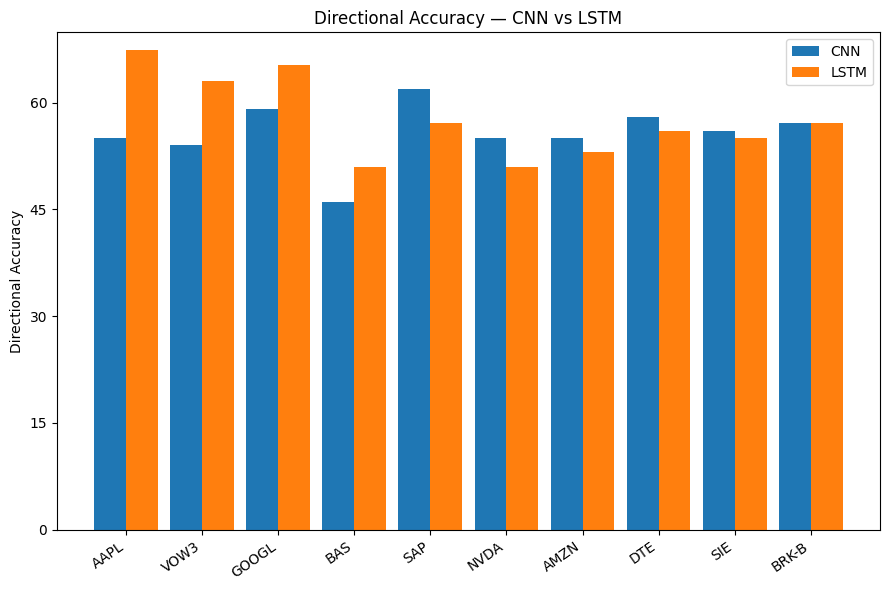

Saved: comparison_outputs_bars\bars_mae_p01.png


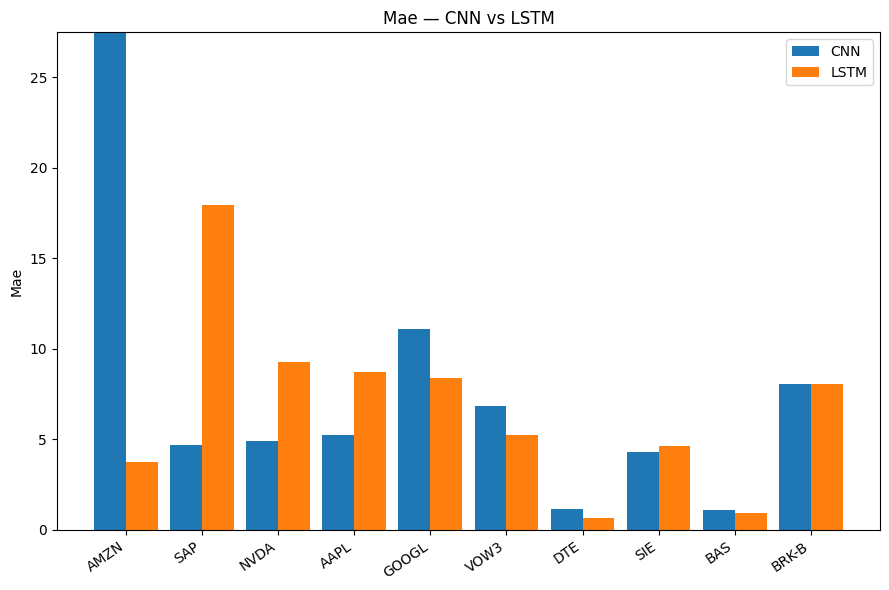

Saved: comparison_outputs_bars\bars_mape__p01.png


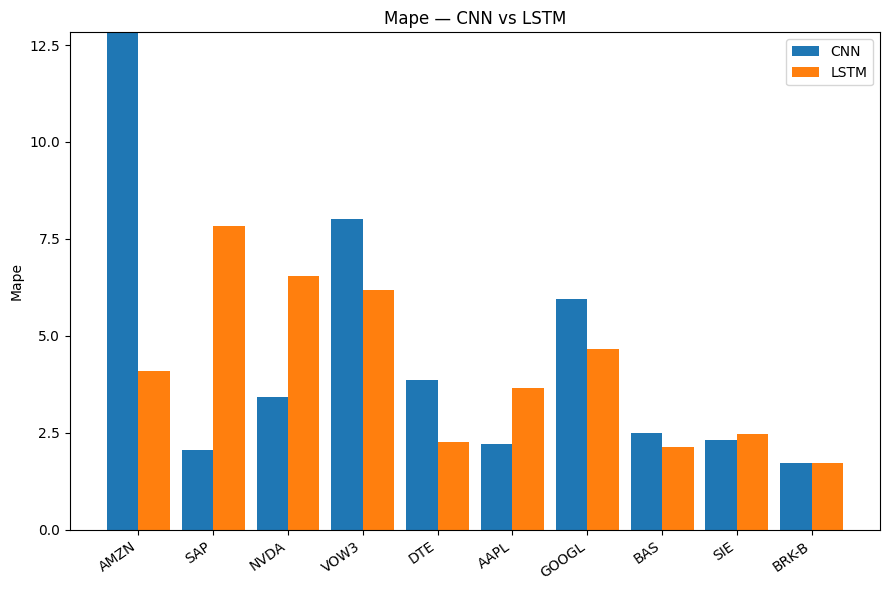

Saved: comparison_outputs_bars\bars_pl_ratio_p01.png


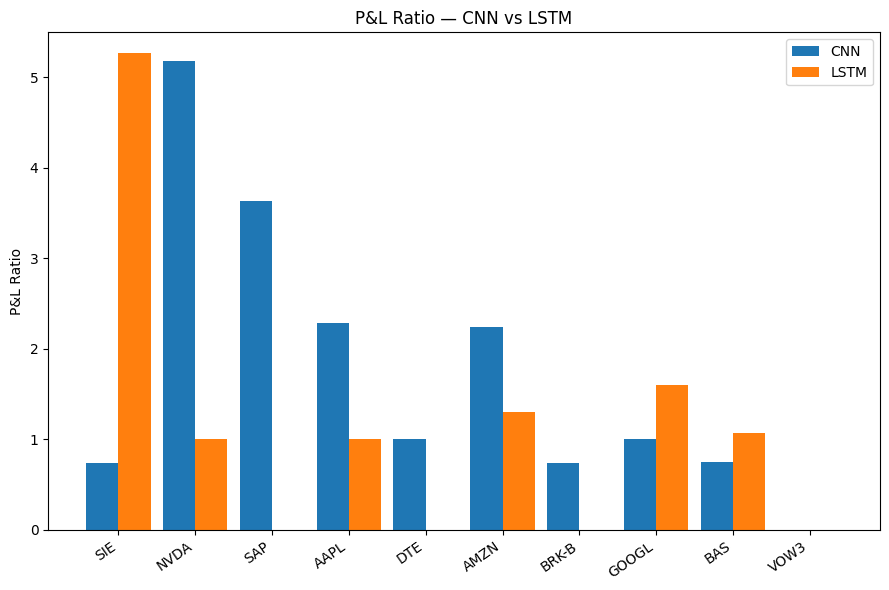

Saved: comparison_outputs_bars\bars_rmse_p01.png


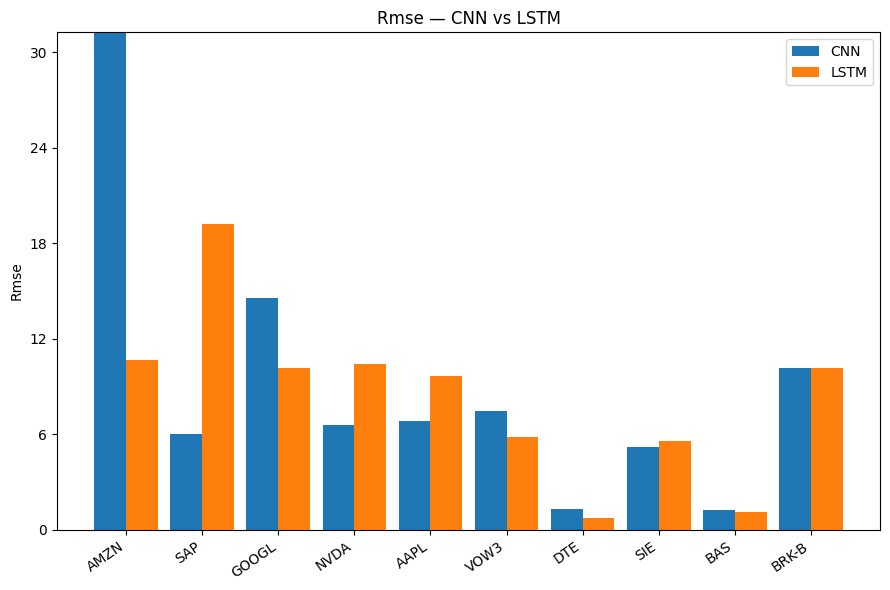

In [24]:
# FIXED: Grouped bar charts per TICKER (CNN vs LSTM), one figure per metric
# - Removes NaN/empty tickers before merge (no more "nan" on x-axis)
# - Splits many tickers into multiple pages (no ultra-wide plots)
# - Clips extreme y-values by percentile so bars stay visible
# - Sets Directional Accuracy axis to [0, 1]
# - Fixes filename bug (no use of .index.start/.stop)

import re
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------- CONFIG ----------
CANDIDATE_CNN  = ["/mnt/data/Mappe_CNN1.xlsx", "Mappe_CNN1.xlsx",
                  "/mnt/data/Mappe_CNN.xlsx",  "Mappe_CNN.xlsx"]
CANDIDATE_LSTM = ["/mnt/data/Mappe_LSTM.xlsx", "Mappe_LSTM.xlsx"]

OUT_DIR       = Path("comparison_outputs_bars"); OUT_DIR.mkdir(parents=True, exist_ok=True)
CHUNK_SIZE    = 18          # tickers per figure
BAR_WIDTH     = 0.42
ROTATION      = 35
CLIP_QUANTILE = 0.98        # set to None to disable
SORT_BY       = "gap"       # "gap" | "cnn" | "lstm" | "alpha"
SAVE_PNG      = True
# ---------------------------

def _first_existing(paths):
    for p in paths:
        if Path(p).exists():
            return Path(p)
    raise FileNotFoundError(f"None of these files exist: {paths}")

CNN_PATH  = _first_existing(CANDIDATE_CNN)
LSTM_PATH = _first_existing(CANDIDATE_LSTM)

def canonical(name: str) -> str:
    s = str(name).strip().lower().replace(" ", "_")
    return re.sub(r"[^a-z0-9_]+", "", s)

def read_first_sheet(path: str | Path) -> pd.DataFrame:
    xl = pd.ExcelFile(path)
    sheet = xl.sheet_names[0]
    df = xl.parse(sheet)
    return df.dropna(axis=1, how="all")

def numeric_cols(df: pd.DataFrame) -> list[str]:
    return [c for c in df.columns if np.issubdtype(df[c].dtype, np.number)]

def find_id_col(df: pd.DataFrame) -> str:
    preferred = {"ticker","symbol","isin","name","company","stock","ticker_symbol","security","asset","ric"}
    canon_map = {canonical(c): c for c in df.columns}
    for k in preferred:
        if k in canon_map:
            return canon_map[k]
    for c in df.columns:  # first non-numeric fallback
        if not np.issubdtype(df[c].dtype, np.number):
            return c
    df["row_id"] = np.arange(len(df))
    return "row_id"

def clean_id_series(s: pd.Series) -> pd.Series:
    s = s.astype(str).str.strip()
    return s.replace({"": np.nan, "nan": np.nan, "None": np.nan, "NaT": np.nan})

def pretty_metric(m: str) -> str:
    mm = m.strip("_").replace("_", " ").title()
    return {"Dir Acc": "Directional Accuracy", "Pl Ratio": "P&L Ratio"}.get(mm, mm)

# ---------- Load ----------
df_cnn_raw  = read_first_sheet(CNN_PATH)
df_lstm_raw = read_first_sheet(LSTM_PATH)

id_cnn  = find_id_col(df_cnn_raw)
id_lstm = find_id_col(df_lstm_raw)

nums_cnn   = [c for c in numeric_cols(df_cnn_raw) if c != id_cnn]
nums_lstm  = [c for c in numeric_cols(df_lstm_raw) if c != id_lstm]
canon_cnn  = {canonical(c): c for c in nums_cnn}
canon_lstm = {canonical(c): c for c in nums_lstm}

shared = sorted(list(set(canon_cnn) & set(canon_lstm)))
if not shared:
    raise ValueError("No common numeric metrics found in the two Excel files.")

df_cnn  = df_cnn_raw[[id_cnn]  + [canon_cnn[k]  for k in shared]].copy()
df_lstm = df_lstm_raw[[id_lstm] + [canon_lstm[k] for k in shared]].copy()
df_cnn.columns  = ["id"] + shared
df_lstm.columns = ["id"] + shared

# drop NaN/empty ids BEFORE joining (prevents 'nan' tickers)
df_cnn["id_norm"]  = clean_id_series(df_cnn["id"])
df_lstm["id_norm"] = clean_id_series(df_lstm["id"])
df_cnn  = df_cnn.dropna(subset=["id_norm"])
df_lstm = df_lstm.dropna(subset=["id_norm"])

merged = pd.merge(
    df_cnn[["id","id_norm"]+shared],
    df_lstm[["id","id_norm"]+shared],
    on="id_norm",
    suffixes=("__CNN","__LSTM"),
    how="inner"
)

merged["Ticker"] = merged["id__CNN"].fillna(merged["id__LSTM"])
merged = merged.drop(columns=["id__CNN","id__LSTM","id_norm"])
merged = merged.dropna(subset=["Ticker"])  # final safety

# tidy columns: Ticker, metric__CNN, metric__LSTM
cols = ["Ticker"]
for m in shared:
    cols += [f"{m}__CNN", f"{m}__LSTM"]
merged = merged[cols].copy()

# Save tidy input
merged.to_csv(OUT_DIR / "merged_cnn_lstm_by_ticker.csv", index=False)

# ---------- Plot helpers ----------
def _chunk_slices(n, size):
    return [slice(i, min(i+size, n)) for i in range(0, n, size)]

def _sort_block(block, metric_key):
    y_cnn  = pd.to_numeric(block[f"{metric_key}__CNN"], errors="coerce")
    y_lstm = pd.to_numeric(block[f"{metric_key}__LSTM"], errors="coerce")
    if SORT_BY == "gap":
        order = (y_cnn - y_lstm).abs().sort_values(ascending=False).index
    elif SORT_BY == "cnn":
        order = y_cnn.sort_values(ascending=False).index
    elif SORT_BY == "lstm":
        order = y_lstm.sort_values(ascending=False).index
    else:
        order = block["Ticker"].astype(str).sort_values().index
    return block.loc[order]

from matplotlib.ticker import MaxNLocator

def _plot_block(block, metric_key, page_no):
    tickers = block["Ticker"].astype(str).tolist()
    x = np.arange(len(tickers))

    y_cnn  = pd.to_numeric(block[f"{metric_key}__CNN"], errors="coerce")
    y_lstm = pd.to_numeric(block[f"{metric_key}__LSTM"], errors="coerce")

    # ---- Directional Accuracy handling (NO 0..1 clamp) ----
    cm = canonical(metric_key)
    is_da = any(k in cm for k in ["diracc", "directionalaccuracy", "directional_acc", "dir_acc"])
    y_label = pretty_metric(metric_key)

    # If DA looks like proportions, show as percent (0–100). Otherwise keep actual numbers.
    if is_da and (np.nanmax([y_cnn.max(), y_lstm.max()]) <= 1.05):
        y_cnn  = y_cnn * 100.0
        y_lstm = y_lstm * 100.0
        y_label = "Directional Accuracy (%)"

    fig_w = max(9, min(20, 0.6 * len(tickers)))
    plt.figure(figsize=(fig_w, 6))
    plt.bar(x - BAR_WIDTH/2, y_cnn,  width=BAR_WIDTH, label="CNN")
    plt.bar(x + BAR_WIDTH/2, y_lstm, width=BAR_WIDTH, label="LSTM")
    plt.xticks(x, tickers, rotation=ROTATION, ha="right")
    plt.ylabel(y_label)
    plt.title(f"{y_label} — CNN vs LSTM")
    plt.legend()

    # Clip extreme outliers to keep bars readable (but NEVER force [0,1])
    if CLIP_QUANTILE is not None:
        vals = pd.concat([y_cnn, y_lstm], axis=0)
        vmax = np.nanpercentile(vals, CLIP_QUANTILE*100.0)
        if np.isfinite(vmax):
            plt.ylim(bottom=min(0, np.nanmin(vals)), top=vmax * 1.05)

    # nicer integer ticks for percents / counts
    ax = plt.gca()
    ax.yaxis.set_major_locator(MaxNLocator(nbins=6, integer=is_da))

    plt.tight_layout()
    if SAVE_PNG:
        safe_metric = canonical(metric_key)
        fname = OUT_DIR / f"bars_{safe_metric}_p{page_no:02d}.png"
        plt.savefig(fname, dpi=160)
        print("Saved:", fname)
    plt.show()


# ---------- Make the plots (paged) ----------
for metric_key in shared:
    dfm = merged.copy()
    dfm[f"{metric_key}__CNN"]  = pd.to_numeric(dfm[f"{metric_key}__CNN"], errors="coerce")
    dfm[f"{metric_key}__LSTM"] = pd.to_numeric(dfm[f"{metric_key}__LSTM"], errors="coerce")
    dfm = dfm[~(dfm[f"{metric_key}__CNN"].isna() & dfm[f"{metric_key}__LSTM"].isna())]

    if len(dfm) == 0:
        print(f"Skipping '{metric_key}': no comparable values.")
        continue

    slices = _chunk_slices(len(dfm), CHUNK_SIZE)
    for page_no, sl in enumerate(slices, start=1):
        block = _sort_block(dfm.iloc[sl], metric_key)
        _plot_block(block, metric_key, page_no)


Saved: feature_usage_outputs\indicator_usage_summary.csv feature_usage_outputs\per_ticker_features_CNN.csv feature_usage_outputs\per_ticker_features_LSTM.csv


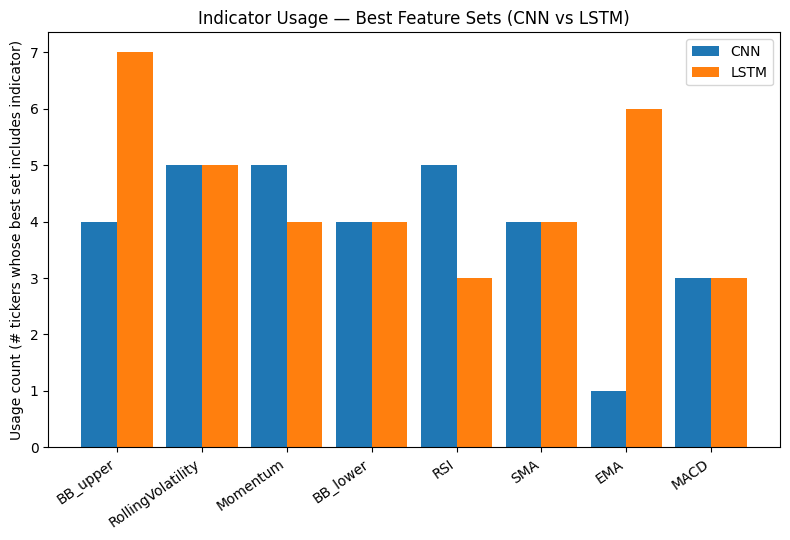

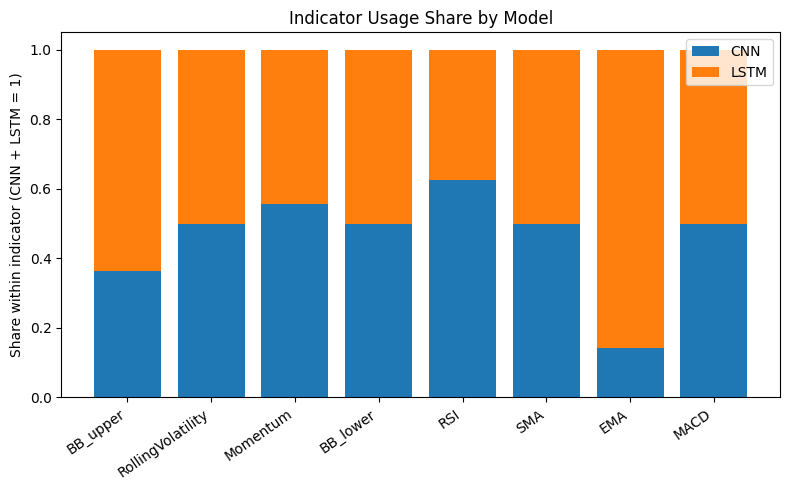

Saved: feature_usage_outputs\indicator_cooccurrence.csv


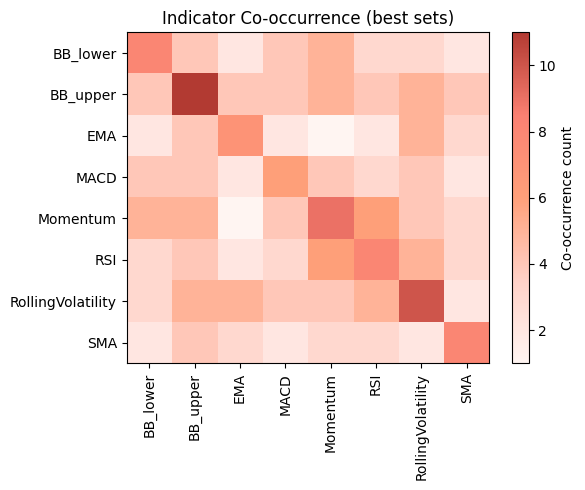

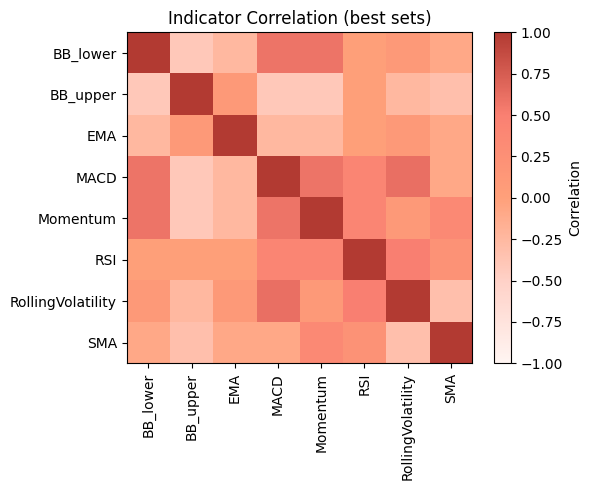

In [25]:
# === Feature-usage from "best features" sets (CNN vs LSTM) ===
# What it does
# 1) Loads two files (Excel/CSV) with per-ticker best feature set for each model.
# 2) Auto-detects the feature-list column (e.g., 'best_features', 'features', ...).
# 3) Parses each row's feature list; normalizes indicator names (RSI, SMA, EMA, MACD, BB_upper, BB_lower, Momentum, RollingVolatility, Log_Return, ...).
# 4) Counts usage per indicator (CNN, LSTM, total) and plots grouped bars.
# 5) (Optional) Computes a co-occurrence matrix and plots it.
#
# Requirements: pandas, numpy, matplotlib

import re, ast
from pathlib import Path
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ----------------- CONFIG -----------------
# Point these to your files (Excel or CSV). First existing path wins.
CANDIDATE_CNN  = ["Mappe_CNN1.xlsx", "Mappe_CNN.xlsx", "/mnt/data/Mappe_CNN1.xlsx", "/mnt/data/Mappe_CNN.xlsx"]
CANDIDATE_LSTM = ["Mappe_LSTM.xlsx", "/mnt/data/Mappe_LSTM.xlsx"]

# If you want to weight counts by a metric (e.g., DA_test), set WEIGHT_COLUMN to that column name.
# If not found or None → each ticker counts as 1 when the indicator is present.
WEIGHT_COLUMN = None  # e.g. "DA_test" or "pnl" or "score"

# Known indicators (helps normalization). Add more if you use others.
INDICATOR_UNIVERSE = {
    "RSI", "SMA", "EMA", "MACD", "Momentum", "BB_upper", "BB_lower",
    "RollingVolatility", "Log_Return", "ATR", "Stochastic", "WilliamsR",
    "ADX", "OBV"
}

OUT_DIR = Path("feature_usage_outputs"); OUT_DIR.mkdir(parents=True, exist_ok=True)
# ------------------------------------------

def _first_existing(paths):
    for p in paths:
        if Path(p).exists():
            return Path(p)
    raise FileNotFoundError(f"None of these files exist: {paths}")

def read_any(path: str | Path) -> pd.DataFrame:
    path = Path(path)
    if path.suffix.lower() in {".xlsx", ".xls"}:
        xl = pd.ExcelFile(path)
        return xl.parse(xl.sheet_names[0]).dropna(axis=1, how="all")
    else:
        return pd.read_csv(path)

def canonical(s: str) -> str:
    return re.sub(r"[^a-z0-9_]+", "", str(s).strip().lower().replace(" ", "_"))

def find_id_col(df: pd.DataFrame) -> str | None:
    prefs = {"ticker","symbol","isin","name","company","stock","ric","ticker_symbol","security","asset"}
    m = {canonical(c): c for c in df.columns}
    for k in prefs:
        if k in m: return m[k]
    # fallback: first non-numeric
    for c in df.columns:
        if not np.issubdtype(df[c].dtype, np.number):
            return c
    return None

def find_features_col(df: pd.DataFrame) -> str:
    # Look for a column whose name suggests 'features' and has list-like strings
    candidates = [c for c in df.columns if any(k in canonical(c) for k in ["feature","featset","bestset","selected"])]
    def looks_like_list(x):
        if pd.isna(x): return False
        s = str(x)
        return any(ch in s for ch in ["[","]","|",",",";","+"]) or " " in s
    for c in candidates:
        sample = df[c].dropna().head(5)
        if len(sample) and sample.map(looks_like_list).mean() > 0:
            return c
    # last resort: try a column literally named 'features'
    if "features" in df.columns: return "features"
    raise ValueError("Couldn't find a column that looks like a 'best features' list.")

# Normalization map for common synonyms/variants
NORMALIZE = {
    "bbupper": "BB_upper", "bb_upper": "BB_upper", "bbup": "BB_upper",
    "bblower": "BB_lower", "bb_lower": "BB_lower", "bblow": "BB_lower",
    "logreturn": "Log_Return", "log_ret": "Log_Return",
    "rollingvolatility": "RollingVolatility", "rollvol": "RollingVolatility", "vol_roll": "RollingVolatility",
    "movavg": "SMA", "ma": "SMA",
    "mom": "Momentum", "williamsr":"WilliamsR"
}

def normalize_token(tok: str) -> str:
    t = tok.strip()
    t = re.sub(r"['\"\s]+", "", t)
    t = t.replace("-", "_")
    c = canonical(t)
    if c in NORMALIZE: return NORMALIZE[c]
    # Preserve underscores/case for known names
    # If it's exactly in the universe (case-insensitive), return canonical title
    for name in INDICATOR_UNIVERSE:
        if canonical(name) == c:
            return name
    # default: return original token with underscores
    return re.sub(r"__+", "_", t)

def parse_features_cell(x) -> list[str]:
    if pd.isna(x): return []
    s = str(x).strip()
    # Try python literal list first, e.g. "['RSI','SMA']"
    try:
        val = ast.literal_eval(s)
        if isinstance(val, (list, tuple, set)):
            toks = [normalize_token(str(t)) for t in val]
            return [t for t in toks if t]
    except Exception:
        pass
    # Otherwise split by common separators
    parts = re.split(r"[,\|\+;]", s)
    if len(parts) == 1:
        # maybe space separated
        parts = re.split(r"\s+", s)
    toks = [normalize_token(p) for p in parts if p.strip()]
    # dedupe within a row
    seen = []
    for t in toks:
        if t and t not in seen:
            seen.append(t)
    return seen

def features_usage(df: pd.DataFrame, model_name: str) -> pd.DataFrame:
    id_col = find_id_col(df)
    feat_col = find_features_col(df)
    if id_col is None:  # create a row id if nothing exists
        df = df.copy()
        df["row_id"] = np.arange(len(df))
        id_col = "row_id"

    # weight
    if WEIGHT_COLUMN and WEIGHT_COLUMN in df.columns:
        w = pd.to_numeric(df[WEIGHT_COLUMN], errors="coerce").fillna(1.0).clip(lower=0)
    else:
        w = pd.Series(1.0, index=df.index)

    # count usage
    counts = {}
    parsed_list = []
    for idx, (tick, fcell, weight) in enumerate(zip(df[id_col], df[feat_col], w)):
        feats = parse_features_cell(fcell)
        parsed_list.append((tick, feats))
        for f in set(feats):  # count each indicator at most once per ticker
            counts[f] = counts.get(f, 0.0) + float(weight)

    # tidy table (per ticker)
    exploded = []
    for tick, feats in parsed_list:
        if not feats:
            exploded.append({"Ticker": tick, "Indicator": np.nan})
        else:
            for f in feats:
                exploded.append({"Ticker": tick, "Indicator": f})
    per_ticker = pd.DataFrame(exploded)

    # usage summary
    usage = (
        per_ticker.dropna(subset=["Indicator"])
                  .groupby("Indicator")
                  .size()
                  .rename(f"count_{model_name}")
                  .to_frame()
    )
    # If weighting used, recompute weighted counts too
    if WEIGHT_COLUMN and WEIGHT_COLUMN in df.columns:
        # rebuild mapping ticker -> weight
        tick_weight = pd.Series(w.values, index=df[id_col].astype(str))
        per_ticker["Ticker_str"] = per_ticker["Ticker"].astype(str)
        weighted = (per_ticker.dropna(subset=["Indicator"])
                    .assign(w=per_ticker["Ticker_str"].map(tick_weight))
                    .groupby("Indicator")["w"].sum()
                    .rename(f"weighted_{model_name}"))
        usage = usage.join(weighted, how="left")

    usage.index.name = "indicator"
    usage = usage.sort_values(by=usage.columns[0], ascending=False)
    return usage, per_ticker, id_col, feat_col

# -------- Load files & compute usage --------
cnn_path  = _first_existing(CANDIDATE_CNN)
lstm_path = _first_existing(CANDIDATE_LSTM)

df_cnn  = read_any(cnn_path)
df_lstm = read_any(lstm_path)

usage_cnn, per_ticker_cnn, id_cnn, feat_cnn = features_usage(df_cnn,  "CNN")
usage_lstm, per_ticker_lstm, id_lstm, feat_lstm = features_usage(df_lstm, "LSTM")

# Merge usage tables
usage = usage_cnn.join(usage_lstm, how="outer").fillna(0)
usage["total"]      = usage.filter(like="count_").sum(axis=1)
usage["share_CNN"]  = np.where(usage["total"]>0, usage["count_CNN"]/usage["total"], 0)
usage["share_LSTM"] = np.where(usage["total"]>0, usage["count_LSTM"]/usage["total"], 0)
usage = usage.sort_values("total", ascending=False)

# Save CSVs
usage.to_csv(OUT_DIR / "indicator_usage_summary.csv")
per_ticker_cnn.to_csv(OUT_DIR / "per_ticker_features_CNN.csv", index=False)
per_ticker_lstm.to_csv(OUT_DIR / "per_ticker_features_LSTM.csv", index=False)
print("Saved:",
      OUT_DIR / "indicator_usage_summary.csv",
      OUT_DIR / "per_ticker_features_CNN.csv",
      OUT_DIR / "per_ticker_features_LSTM.csv")

# -------- PLOTS: grouped bars (usage counts) --------
indicators = usage.index.tolist()
x = np.arange(len(indicators))
w = 0.42

plt.figure(figsize=(max(8, 0.6*len(indicators)), 5.5))
plt.bar(x - w/2, usage["count_CNN"],  width=w, label="CNN")
plt.bar(x + w/2, usage["count_LSTM"], width=w, label="LSTM")
plt.xticks(x, indicators, rotation=35, ha="right")
plt.ylabel("Usage count (# tickers whose best set includes indicator)")
plt.title("Indicator Usage — Best Feature Sets (CNN vs LSTM)")
plt.legend()
plt.tight_layout()
plt.savefig(OUT_DIR / "indicator_usage_counts.png", dpi=160)
plt.show()

# -------- OPTIONAL: stacked share bars (who uses it more) --------
plt.figure(figsize=(max(8, 0.6*len(indicators)), 5.0))
plt.bar(x, usage["share_CNN"], label="CNN")
plt.bar(x, usage["share_LSTM"], bottom=usage["share_CNN"], label="LSTM")
plt.xticks(x, indicators, rotation=35, ha="right")
plt.ylabel("Share within indicator (CNN + LSTM = 1)")
plt.title("Indicator Usage Share by Model")
plt.legend()
plt.tight_layout()
plt.savefig(OUT_DIR / "indicator_usage_share.png", dpi=160)
plt.show()

# -------- OPTIONAL: co-occurrence matrix across models combined --------
# Build combined per-ticker indicator sets (CNN + LSTM)
sets = {}
for df, id_col, feat_col, tag in [(df_cnn, id_cnn, feat_cnn, "CNN"), (df_lstm, id_lstm, feat_lstm, "LSTM")]:
    for _, row in df.iterrows():
        tick = str(row[id_col]) if id_col in row else f"{tag}_{_}"
        feats = set(parse_features_cell(row[feat_col]))
        if not feats: continue
        sets[(tag, tick)] = feats

all_inds = sorted(set.union(*[s for s in sets.values()]) if sets else set())
co = pd.DataFrame(0, index=all_inds, columns=all_inds, dtype=int)
for feats in sets.values():
    for a, b in itertools.combinations(sorted(feats), 2):
        co.loc[a, b] += 1
        co.loc[b, a] += 1
    # diagonal: count of occurrences (co-occur with itself)
    for a in feats:
        co.loc[a, a] += 1

co.to_csv(OUT_DIR / "indicator_cooccurrence.csv")
print("Saved:", OUT_DIR / "indicator_cooccurrence.csv")

# --- Salmon colormap heatmap (replaces the old heatmap block) ---
from matplotlib.colors import LinearSegmentedColormap

# soft→salmon→dark salmon ramp
salmon_cmap = LinearSegmentedColormap.from_list(
    "salmon_ramp",
    ["#fff5f2", "#ffd1c7", "#FFA07A", "#FA8072", "#b23a32"]
)

plt.figure(figsize=(max(6, 0.45*len(all_inds)), max(5, 0.45*len(all_inds))))
plt.imshow(co.values, aspect="auto", cmap=salmon_cmap)
plt.xticks(np.arange(len(all_inds)), all_inds, rotation=90)
plt.yticks(np.arange(len(all_inds)), all_inds)
plt.colorbar(label="Co-occurrence count")
plt.title("Indicator Co-occurrence (best sets)")
plt.tight_layout()
plt.savefig(OUT_DIR / "indicator_cooccurrence_heatmap_salmon.png", dpi=160)
plt.show()
# Build a binary presence matrix (rows=tickers, cols=indicators), then correlate
presence = pd.DataFrame(0, index=pd.Index([k for _, k in sets.keys()], name="Ticker"),
                        columns=all_inds, dtype=int)
for (_, tick), feats in sets.items():
    for f in feats:
        presence.loc[tick, f] = 1

corr = presence.corr()

plt.figure(figsize=(max(6, 0.45*len(all_inds)), max(5, 0.45*len(all_inds))))
plt.imshow(corr.values, aspect="auto", cmap=salmon_cmap, vmin=-1, vmax=1)
plt.xticks(np.arange(len(all_inds)), all_inds, rotation=90)
plt.yticks(np.arange(len(all_inds)), all_inds)
plt.colorbar(label="Correlation")
plt.title("Indicator Correlation (best sets)")
plt.tight_layout()
plt.savefig(OUT_DIR / "indicator_correlation_heatmap_salmon.png", dpi=160)
plt.show()
